In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.datasets import make_classification
from collections import Counter
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import time

In [378]:
dataset = pd.read_csv('/content/Telecom Customers Churn.csv')
dataset.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [379]:
dataset = dataset.drop(['customerID'], axis=1)
dataset.head()

gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0              Yes           Electronic check           29.85        29.85   
1               No               Mailed check           56.95       1889.5   
2              Yes               Mailed check           53.85       108.15   
3               No  Bank transfer (automatic)           42.30      1840.75   
4              Yes           Electronic check           70.70       151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

In [380]:
# Label ecoder on churn and contract
label_col = ['Churn', 'Contract']

# Convert categorical columns to numeric using LabelEncoder
label_encoder = {}
for column in label_col :
    label = LabelEncoder()
    dataset[column] = label.fit_transform(dataset[column])
    label_encoder[column] = label
dataset.head()

gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies  Contract  \
0               No          No          No              No         0   
1              Yes          No          No              No         1   
2               No          No          No              No         0   
3              Yes         Yes          No              No         1   
4               No          No          No              No         0   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0              Yes           Electronic check           29.85        29.85   
1               No               Mailed check           56.95       1889.5   
2              Yes               Mailed check           53.85       108.15   
3               No  Bank transfer (automatic)           42.30      1840.75   
4              Yes           Electronic check           70.70       151.65   

   Churn  
0      0  
1      0  
2      1  
3      0  
4      1

In [381]:
# getting Categorical Data

df_cat = dataset.columns[dataset.dtypes == 'O']
df_cat

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling',
       'PaymentMethod', 'TotalCharges'],
      dtype='object')

In [382]:
# getting numeric columns

# df_num = dataset.columns[dataset.dtypes != 'O']
df_num=dataset.columns[dataset.dtypes!='O'].tolist()
df_num

['SeniorCitizen', 'tenure', 'Contract', 'MonthlyCharges', 'Churn']

In [383]:
df_num.append('TotalCharges')
df_num

['SeniorCitizen',
 'tenure',
 'Contract',
 'MonthlyCharges',
 'Churn',
 'TotalCharges']

In [384]:
# Convert TotalCharges to float, replacing ' ' with NaN
dataset['TotalCharges'] = pd.to_numeric(dataset['TotalCharges'], errors='coerce')

In [385]:
# all are new customers thats why it is empty as told by tenure column
# If there are still missing values after this step, use median imputation
dataset['TotalCharges'] = dataset['TotalCharges'].fillna(dataset['TotalCharges'].mean())

In [386]:
# finding categorical columns again after removing numeric total charges and after label encoding

df_cat=dataset.columns[dataset.dtypes=='O']
df_cat

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling',
       'PaymentMethod'],
      dtype='object')

In [387]:
# one hot encoding of categorical columns

from sklearn.preprocessing import OneHotEncoder


encoder = OneHotEncoder(sparse=False)

encoded_data = encoder.fit_transform(dataset[df_cat])

encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out())

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [388]:
# remving old and joining new columns

dataset = pd.concat([dataset, pd.get_dummies(dataset[df_cat])], axis=1)

dataset = dataset.drop(df_cat, axis=1)

In [389]:
dataset.head()

SeniorCitizen  tenure  Contract  MonthlyCharges  TotalCharges  Churn  \
0              0       1         0           29.85         29.85      0   
1              0      34         1           56.95       1889.50      0   
2              0       2         0           53.85        108.15      1   
3              0      45         1           42.30       1840.75      0   
4              0       2         0           70.70        151.65      1   

   gender_Female  gender_Male  Partner_No  Partner_Yes  ...  StreamingTV_Yes  \
0           True        False       False         True  ...            False   
1          False         True        True        False  ...            False   
2          False         True        True        False  ...            False   
3          False         True        True        False  ...            False   
4           True        False        True        False  ...            False   

   StreamingMovies_No  StreamingMovies_No internet service  \
0                True                                False   
1                True                                False   
2                True                                False   
3                True                                False   
4                True                                False   

   StreamingMovies_Yes  PaperlessBilling_No  PaperlessBilling_Yes  \
0                False                False                  True   
1                False                 True                 False   
2                False                False                  True   
3                False                 True                 False   
4                False                False                  True   

   PaymentMethod_Bank transfer (automatic)  \
0                                    False   
1                                    False   
2                                    False   
3                                     True   
4                                    False   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                  False                            True   
1                                  False                           False   
2                                  False                           False   
3                                  False                           False   
4                                  False                            True   

   PaymentMethod_Mailed check  
0                       False  
1                        True  
2                        True  
3                       False  
4                       False  

[5 rows x 44 columns]

In [390]:
dataset = pd.DataFrame(dataset)
dataset['MonthlyCharges*TotalCharges'] = dataset.apply(lambda x : float(x['MonthlyCharges']) * float(x['TotalCharges']), axis = 1)    # if Many => 1
dataset['MonthlyCharges*TotalCharges'] = dataset.apply(lambda x : float(x['MonthlyCharges']) + float(x['TotalCharges']), axis = 1)    # if Many => 1
dataset['MonthlyCharges*tenure'] = dataset.apply(lambda x : float(x['MonthlyCharges']) * float(x['tenure']), axis = 1)    # if Many => 1
dataset['MonthlyCharges/tenure'] = dataset.apply(lambda x : float(x['MonthlyCharges']) / float(x['tenure']) if x['tenure'] != 0 else 0, axis = 1)    # if Many => 1

In [391]:
dataset.head()

SeniorCitizen  tenure  Contract  MonthlyCharges  TotalCharges  Churn  \
0              0       1         0           29.85         29.85      0   
1              0      34         1           56.95       1889.50      0   
2              0       2         0           53.85        108.15      1   
3              0      45         1           42.30       1840.75      0   
4              0       2         0           70.70        151.65      1   

   gender_Female  gender_Male  Partner_No  Partner_Yes  ...  \
0           True        False       False         True  ...   
1          False         True        True        False  ...   
2          False         True        True        False  ...   
3          False         True        True        False  ...   
4           True        False        True        False  ...   

   StreamingMovies_Yes  PaperlessBilling_No  PaperlessBilling_Yes  \
0                False                False                  True   
1                False                 True                 False   
2                False                False                  True   
3                False                 True                 False   
4                False                False                  True   

   PaymentMethod_Bank transfer (automatic)  \
0                                    False   
1                                    False   
2                                    False   
3                                     True   
4                                    False   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                  False                            True   
1                                  False                           False   
2                                  False                           False   
3                                  False                           False   
4                                  False                            True   

   PaymentMethod_Mailed check  MonthlyCharges*TotalCharges  \
0                       False                        59.70   
1                        True                      1946.45   
2                        True                       162.00   
3                       False                      1883.05   
4                       False                       222.35   

   MonthlyCharges*tenure  MonthlyCharges/tenure  
0                  29.85                 29.850  
1                1936.30                  1.675  
2                 107.70                 26.925  
3                1903.50                  0.940  
4                 141.40                 35.350  

[5 rows x 47 columns]

In [392]:
# senior citizens are not numeric it should not be in it

df_num.remove('SeniorCitizen')
df_num.remove('Churn')

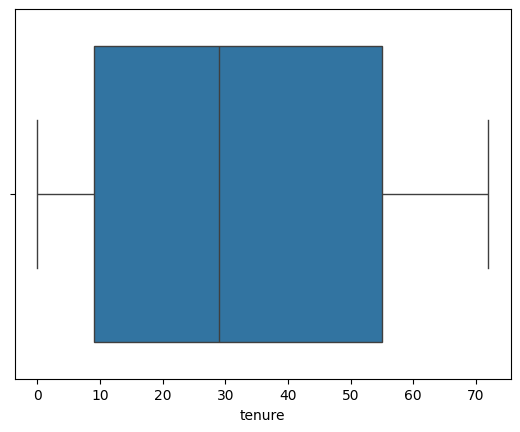

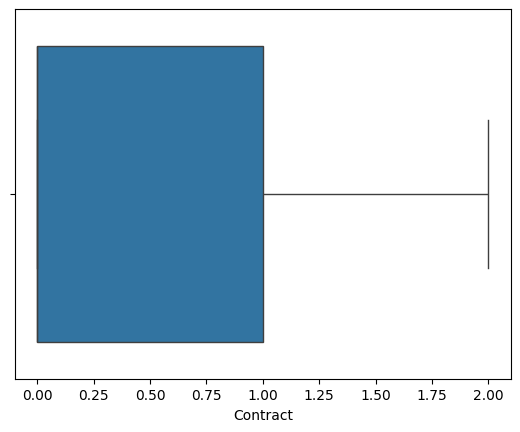

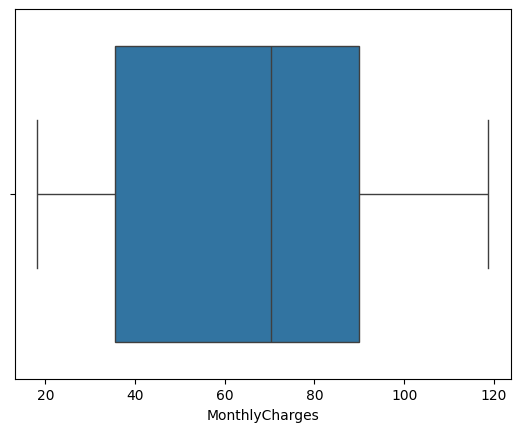

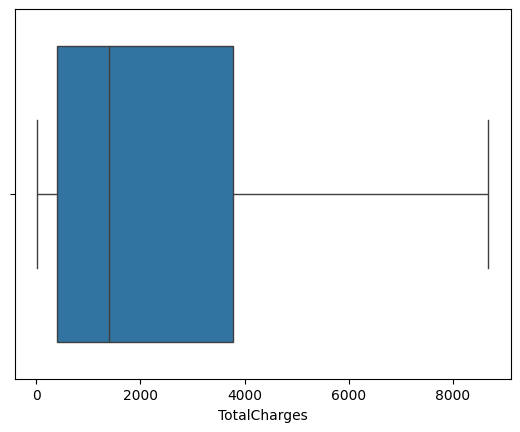

In [393]:
# visualizing outliers by box plot

for i in df_num:
    sns.boxplot(x=dataset[i])
    plt.show()

In [394]:
# Detecting outliers

def detect_outliers_iqr(series):
  q1, q3 = series.quantile([0.25, 0.75])
  iqr = q3 - q1
  lower_bound = q1 - 1.5 * iqr
  upper_bound = q3 + 1.5 * iqr
  return series[(series < lower_bound) | (series > upper_bound)]


for i in df_num:
    print(detect_outliers_iqr(dataset[i]))

Series([], Name: tenure, dtype: int64)
Series([], Name: Contract, dtype: int64)
Series([], Name: MonthlyCharges, dtype: float64)
Series([], Name: TotalCharges, dtype: float64)


In [395]:
# checking skewness of numeric data

for i in df_num:
    print(i,':',dataset[i].skew())

tenure : 0.2395397495619829
Contract : 0.6309590983751753
MonthlyCharges : -0.22052443394398033
TotalCharges : 0.9623940229874866


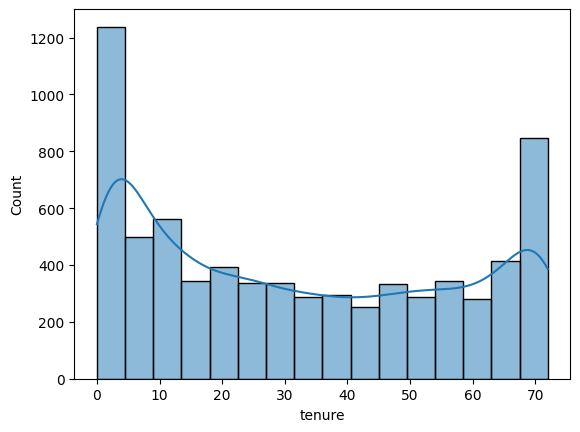

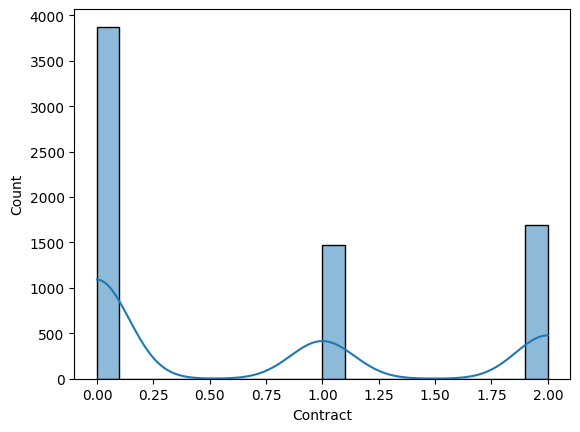

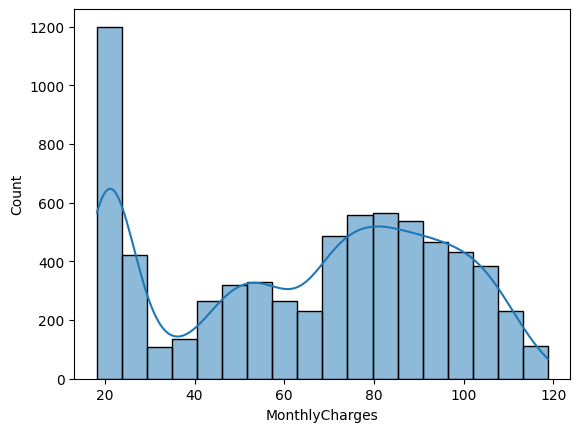

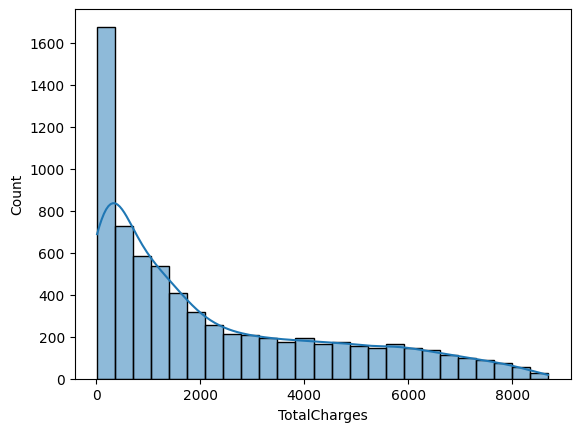

In [396]:
# Seeing visualization of data to understand skewness

import matplotlib.pyplot as plt
for i in df_num:
    sns.histplot(dataset[i],kde=True)
    plt.show()

In [397]:
# using sqrt transformation
dataset['TotalCharges'] = np.sqrt(dataset['TotalCharges'])

# Check the skewness of the transformed data
print(dataset['TotalCharges'].skew())

0.30784903124051693


<Axes: xlabel='TotalCharges', ylabel='Count'>

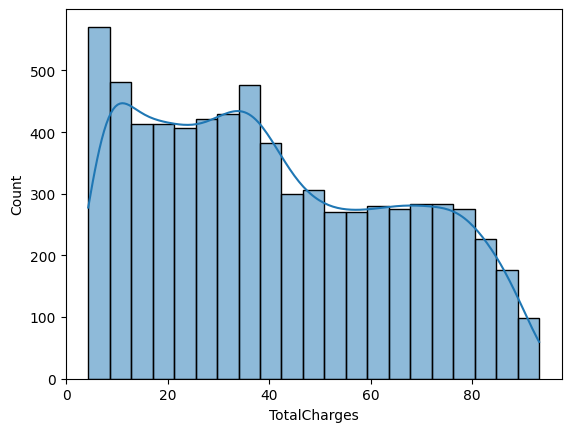

In [398]:
# skewness of transformed data
sns.histplot(dataset['TotalCharges'],kde=True)

In [399]:
# Split dataset into features (X) and target (y)
X = dataset.drop('Churn', axis=1)
y = dataset['Churn']


In [400]:
# Apply SMOTEENN for both oversampling and cleaning
smote_enn = SMOTEENN(random_state=42)
X_res, y_res = smote_enn.fit_resample(X, y)

df = pd.concat([X_res, y_res], axis=1)

print(pd.Series(y_res).value_counts())

Churn
1    3298
0    2711
Name: count, dtype: int64


In [401]:
# scaling columns using standard scaler

cols_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges', 'MonthlyCharges*TotalCharges', 'MonthlyCharges*TotalCharges', 'MonthlyCharges*tenure', 'MonthlyCharges/tenure',
                #  'MonthlyCharges+TotalCharges',
                #  '(MonthlyCharges*TotalCharges)/tenure'
                 ]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])


<Axes: >

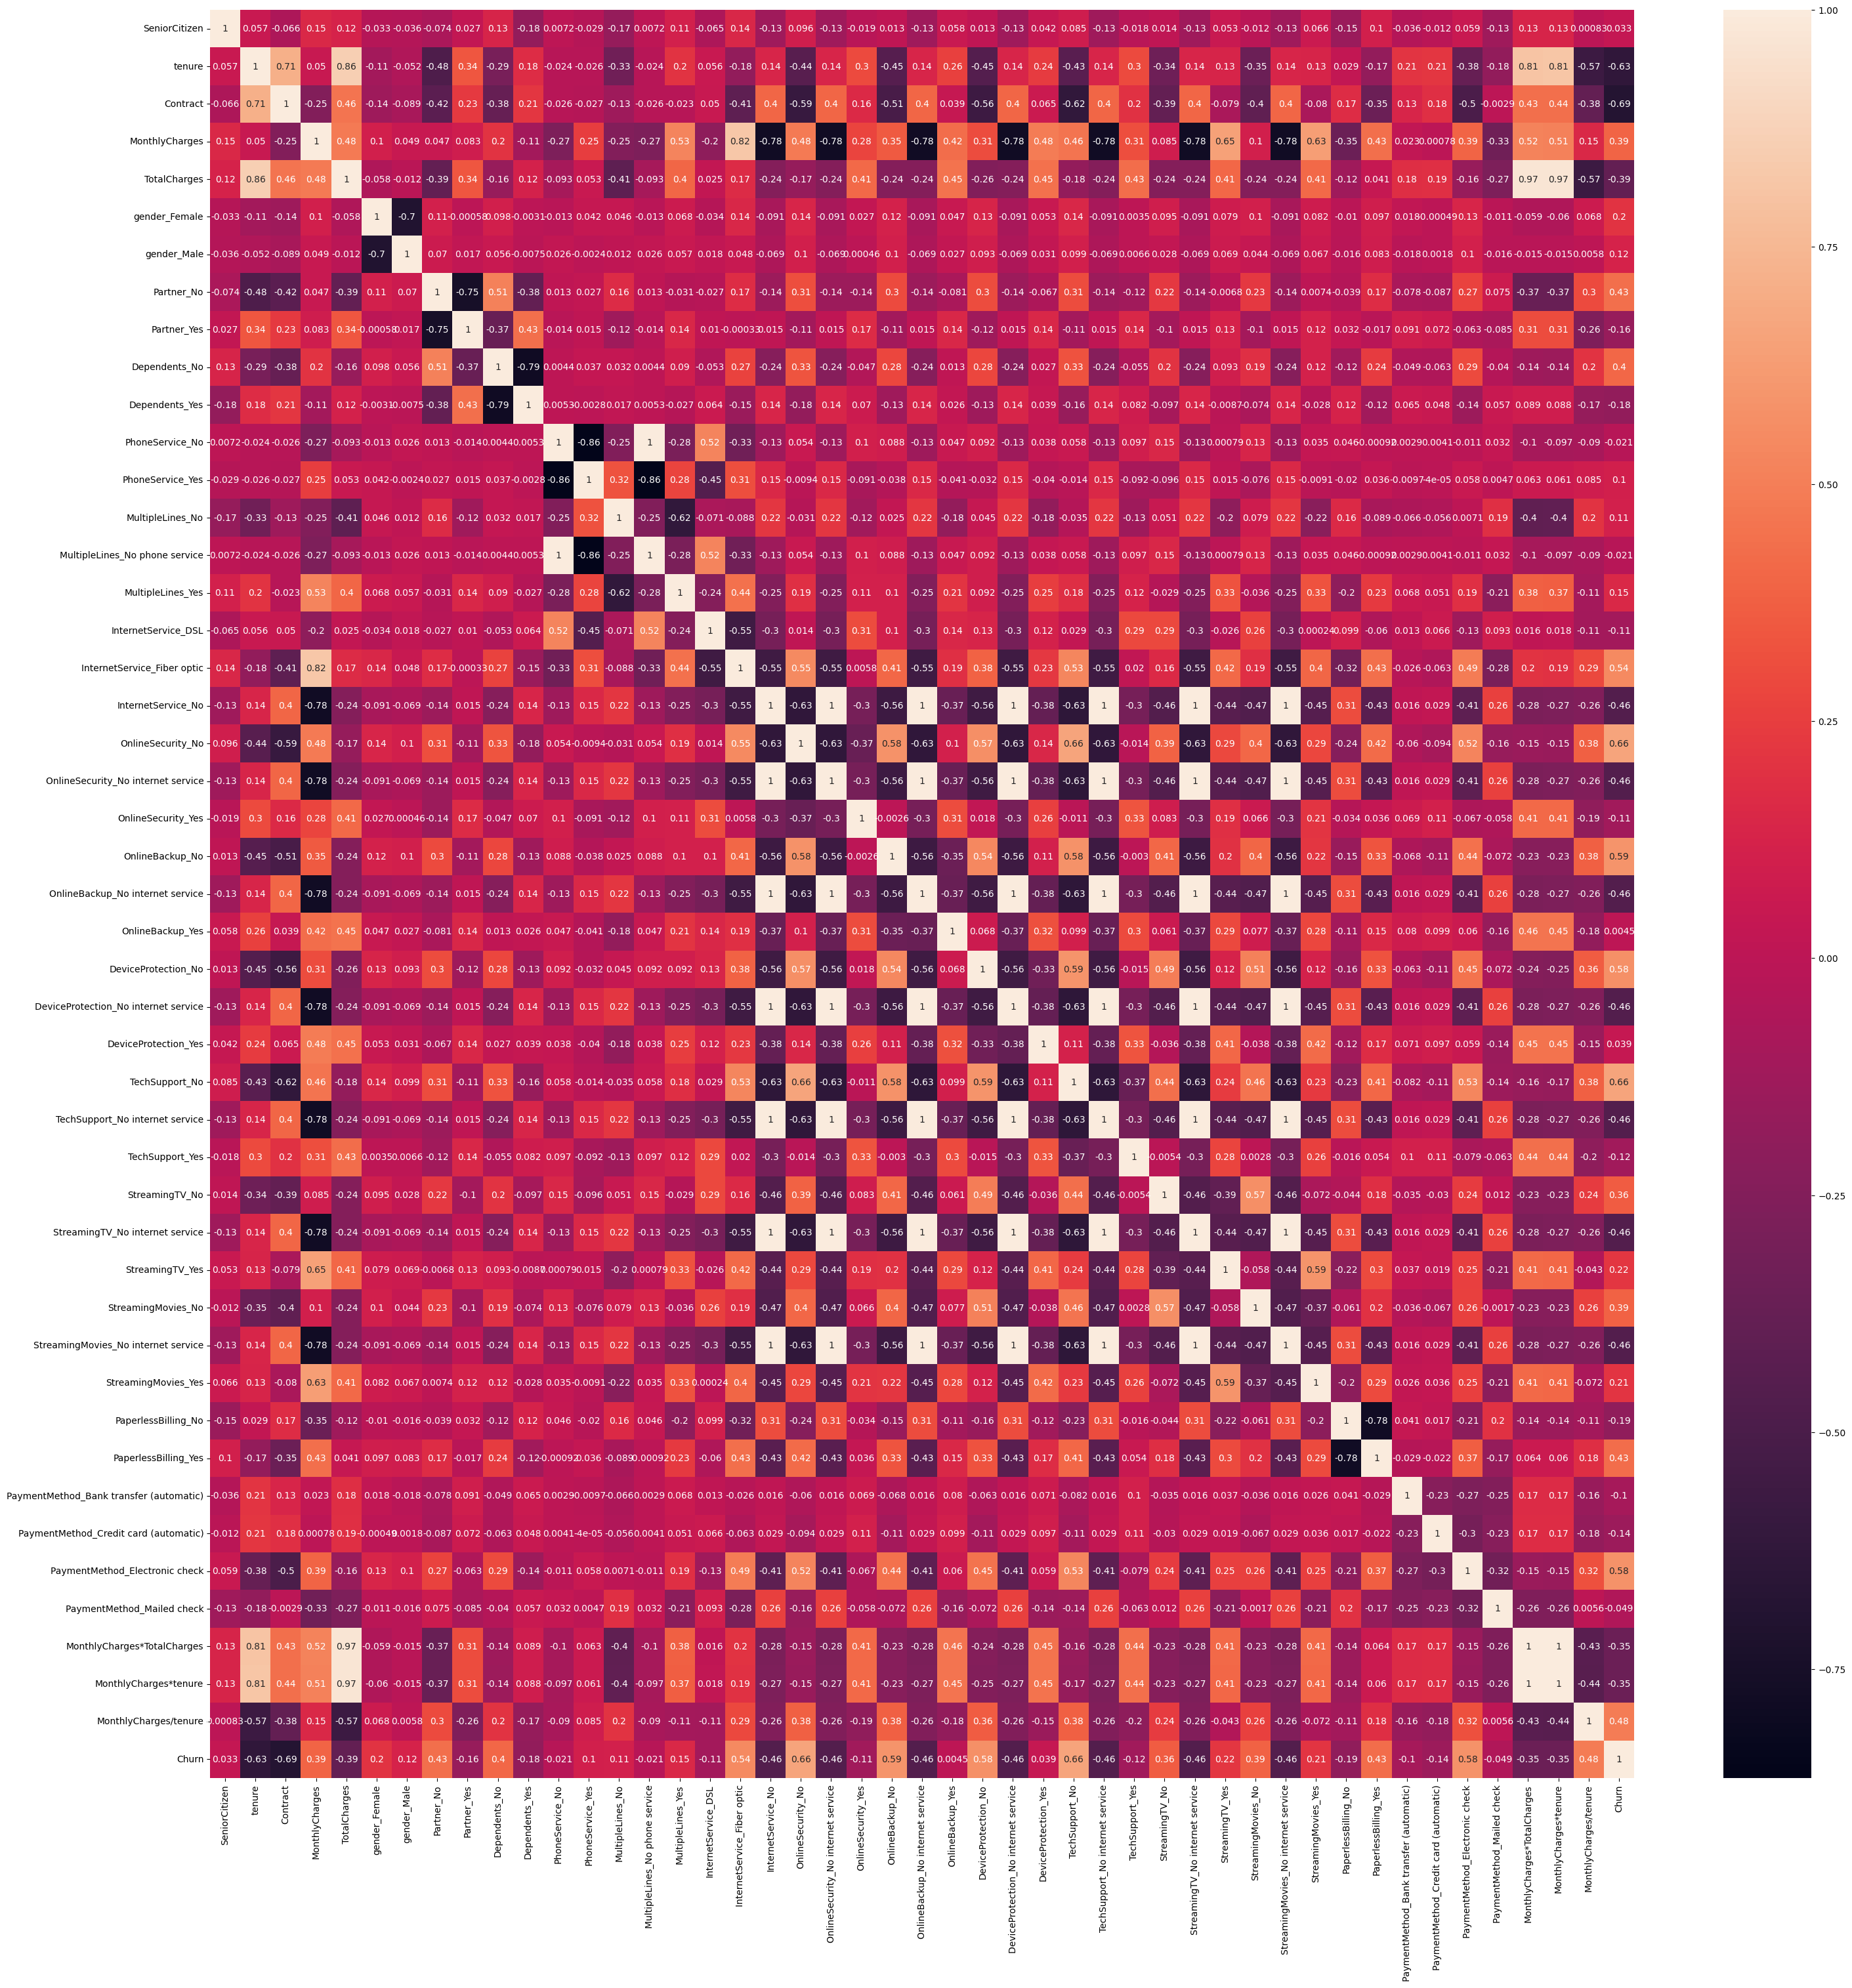

In [402]:
# visualizing co-relation bw the features

plt.figure(figsize=(35, 35))
sns.heatmap(df.corr(), annot=True)

In [403]:
from sklearn.feature_selection import mutual_info_regression

In [404]:
# checking mutual information scores

def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [405]:
X=df.drop(columns='Churn')
y=df['Churn']

In [406]:
miscores=make_mi_scores(X,y)
miscores

MonthlyCharges/tenure                      0.392934
Contract                                   0.298916
tenure                                     0.248548
TechSupport_No                             0.243213
MonthlyCharges*tenure                      0.242571
OnlineSecurity_No                          0.231024
TotalCharges                               0.223352
MonthlyCharges*TotalCharges                0.213490
MonthlyCharges                             0.208773
PaymentMethod_Electronic check             0.181659
OnlineBackup_No                            0.174135
DeviceProtection_No                        0.166302
InternetService_Fiber optic                0.150598
DeviceProtection_No internet service       0.136264
TechSupport_No internet service            0.132795
StreamingMovies_No internet service        0.126504
OnlineBackup_No internet service           0.113259
OnlineSecurity_No internet service         0.112220
InternetService_No                         0.106018
StreamingTV_No internet service            0.100218
PaperlessBilling_Yes                       0.100041
Partner_No                                 0.088491
StreamingMovies_No                         0.083903
Dependents_No                              0.076782
StreamingTV_No                             0.065666
StreamingTV_Yes                            0.046657
gender_Female                              0.026879
StreamingMovies_Yes                        0.020658
gender_Male                                0.020256
Dependents_Yes                             0.017883
PaymentMethod_Bank transfer (automatic)    0.016079
PhoneService_Yes                           0.015826
PaperlessBilling_No                        0.014052
MultipleLines_No                           0.011159
PaymentMethod_Credit card (automatic)      0.009916
Partner_Yes                                0.008424
SeniorCitizen                              0.008238
PaymentMethod_Mailed check                 0.007095
DeviceProtection_Yes                       0.001920
TechSupport_Yes                            0.000000
PhoneService_No                            0.000000
OnlineBackup_Yes                           0.000000
MultipleLines_No phone service             0.000000
OnlineSecurity_Yes                         0.000000
MultipleLines_Yes                          0.000000
InternetService_DSL                        0.000000
Name: MI Scores, dtype: float64

In [407]:
# plotting mutual information scores

def plot_mi_scores(scores):
    plt.figure(figsize=(25,25))
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

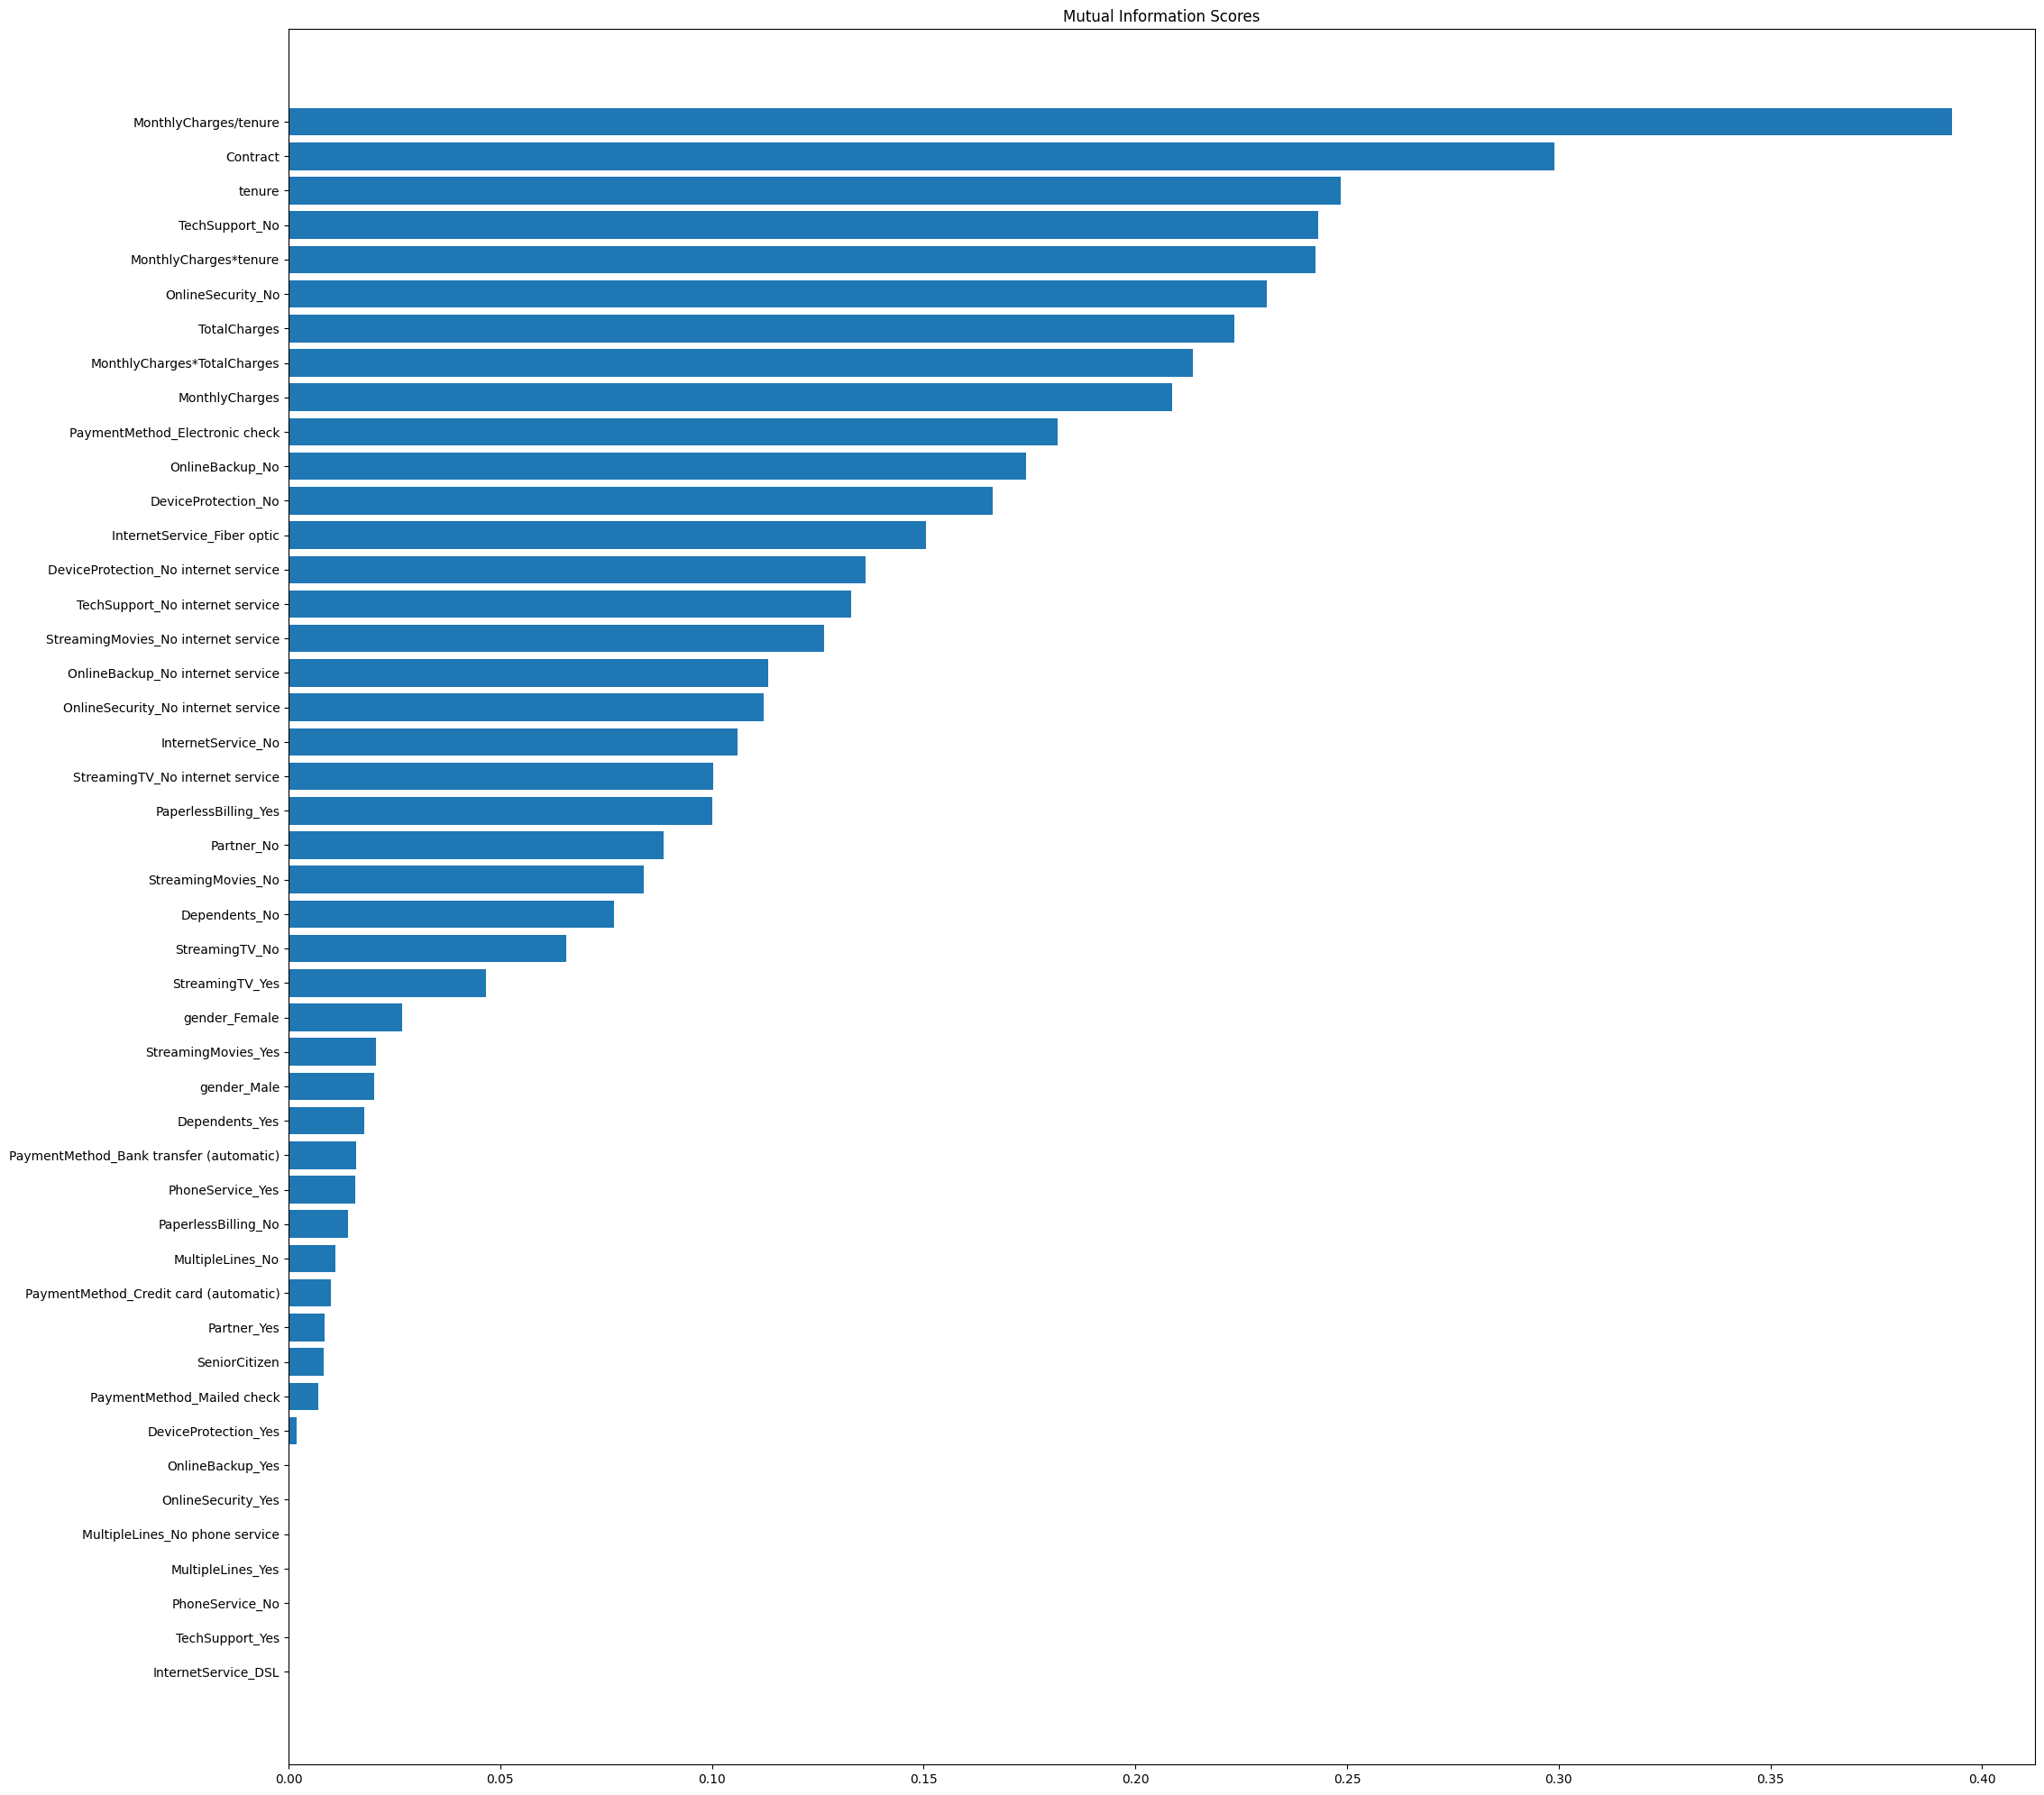

In [408]:
plot_mi_scores(miscores)

In [409]:
def filter_correlated_features(df, target_col, threshold=0.8):
  """Filters features based on correlation, excluding features highly correlated with the target.

  Args:
    df: The DataFrame containing the features.
    target_col: The name of the target column.
    threshold: The correlation threshold.

  Returns:
    A list of feature names to keep.
  """

  corr_matrix = df.corr()
  upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
  to_drop = [column for column in upper_tri.columns if any(upper_tri[column] >= threshold) and column != target_col]
  return df.drop(to_drop, axis=1)

In [410]:
# dropping columns which are highly co-related

df=filter_correlated_features(df,'Churn',0.6)

len(df.columns)

32

In [413]:
# Split data
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)


In [414]:
# using logistic regression to know how well steps works
model = LogisticRegression(max_iter=1000)

# Train the model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [415]:
# score
score = model.score(X_train, y_train)
print(f'Score : {score : }')
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Classification Report
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_rep)

Score :  0.9448720615768671
Accuracy: 0.937603993344426
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.96      0.93       562
           1       0.96      0.92      0.94       640

    accuracy                           0.94      1202
   macro avg       0.94      0.94      0.94      1202
weighted avg       0.94      0.94      0.94      1202



[[539  23]
 [ 52 588]]


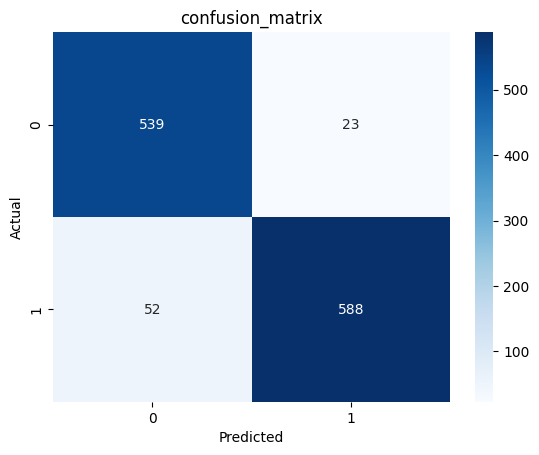

In [416]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues')
plt.title('confusion_matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

ROC AUC Score: 0.9852313167259786


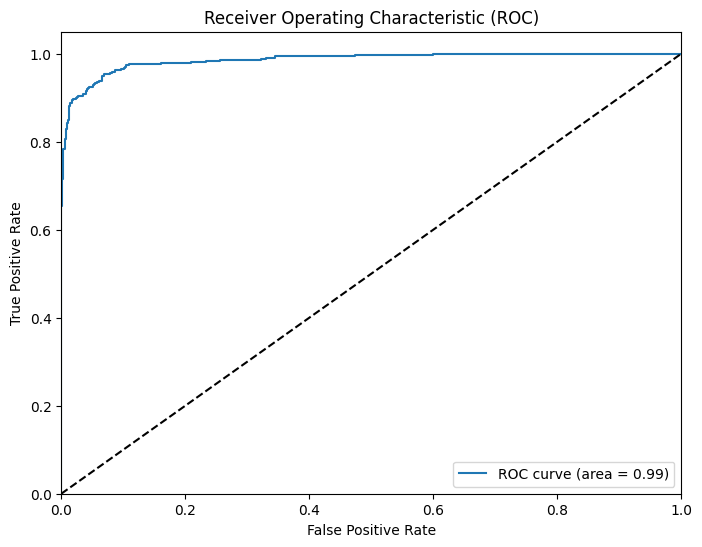

In [412]:
# prompt: provide me roc accuracy and roc accuracy curve

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict probabilities for the positive class
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [418]:
# Initialize and train the RandomForest model
random = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 200)   # Random_state = 2 is the best
random.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rand = random.predict(X_test)

In [419]:
# Evaluate the model
score = random.score(X_train, y_train)
print(f'Score : {score : }')
accuracy =  accuracy_score(y_test, y_pred_rand)
print(f'Accuracy : {accuracy : }')
# Classification Report
print(classification_report(y_test, y_pred_rand))

Score :  1.0
Accuracy :  0.9442595673876872
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       562
           1       0.96      0.93      0.95       640

    accuracy                           0.94      1202
   macro avg       0.94      0.94      0.94      1202
weighted avg       0.94      0.94      0.94      1202



[[537  25]
 [ 42 598]]


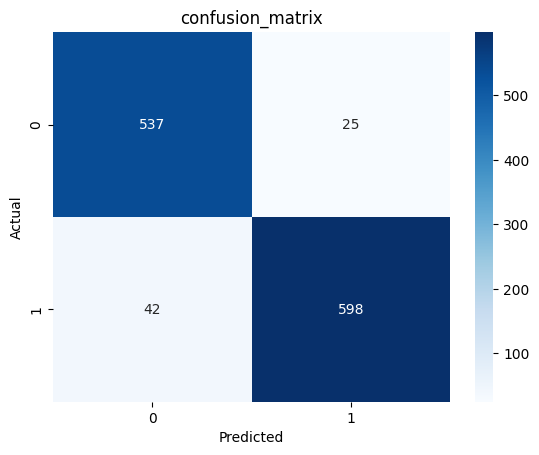

In [420]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_rand)
print(conf_matrix)
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues')
plt.title('confusion_matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

ROC AUC Score: 0.9837800266903913


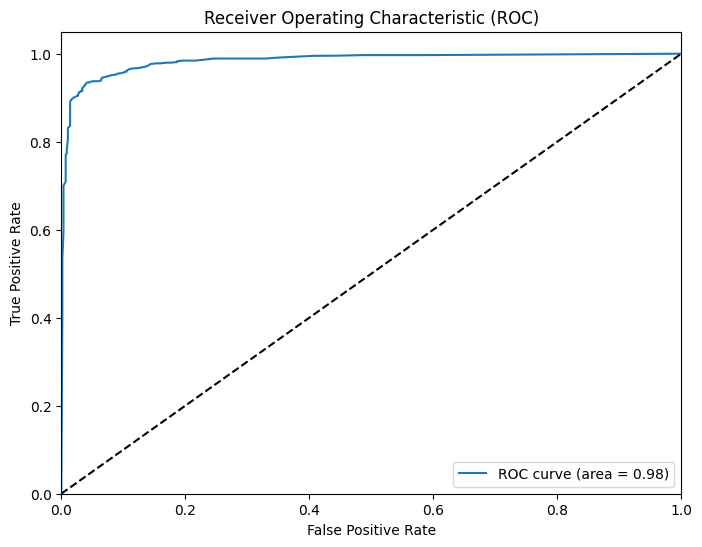

In [421]:
 # roc accuracy and roc accuracy curve

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict probabilities for the positive class
y_pred_proba = random.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# random_state = 42
# Score :  1.0
# Accuracy :  0.9434276206322796
# Confusion Matrix:
#  [[533  29]
#  [ 39 601]]
#               precision    recall  f1-score   support

#            0       0.93      0.95      0.94       562
#            1       0.95      0.94      0.95       640

#     accuracy                           0.94      1202
#    macro avg       0.94      0.94      0.94      1202
# weighted avg       0.94      0.94      0.94      1202

In [422]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

In [423]:
# Evaluate the model
score = xgb.score(X_train, y_train)
print(f'Score : {score : }')
accuracy =  accuracy_score(y_test, y_pred_xgb)
print(f'Accuracy : {accuracy : }')
# Classification Report
print(classification_report(y_test, y_pred_xgb))

Score :  0.9993759101310589
Accuracy :  0.9409317803660566
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       562
           1       0.95      0.93      0.94       640

    accuracy                           0.94      1202
   macro avg       0.94      0.94      0.94      1202
weighted avg       0.94      0.94      0.94      1202



[[533  29]
 [ 42 598]]


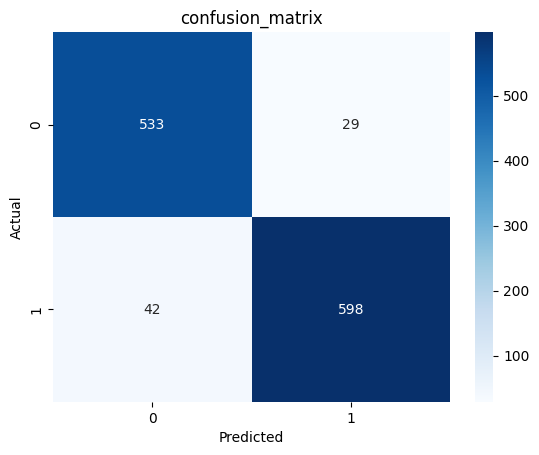

In [425]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
print(conf_matrix)
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues')
plt.title('confusion_matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

ROC AUC Score: 0.985348087188612


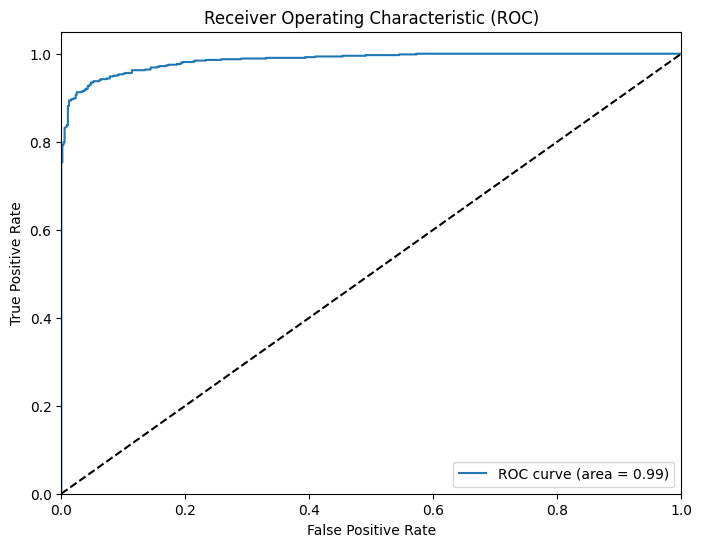

In [426]:
# roc accuracy and roc accuracy curve

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict probabilities for the positive class
y_pred_proba = xgb.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [427]:
# Initialize and train the GaussianNB model
gnb = GaussianNB()
gnb.fit(X_train, y_train)
# Predict on the test set
y_pred_gnb = gnb.predict(X_test)

In [429]:
# Evaluate the model
score = gnb.score(X_train, y_train)
print(f'Score : {score : }')
accuracy =  accuracy_score(y_test, y_pred_gnb)
print(f'Accuracy : {accuracy : }')
# Classification Report
print(classification_report(y_test, y_pred_gnb))

Score :  0.8939047222800083
Accuracy :  0.8835274542429284
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       562
           1       0.92      0.85      0.89       640

    accuracy                           0.88      1202
   macro avg       0.88      0.89      0.88      1202
weighted avg       0.89      0.88      0.88      1202



[[517  45]
 [ 95 545]]


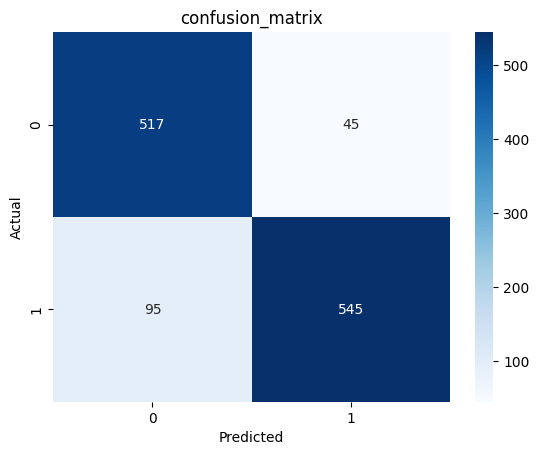

In [430]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_gnb)
print(conf_matrix)
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues')
plt.title('confusion_matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

ROC AUC Score: 0.9551267793594307


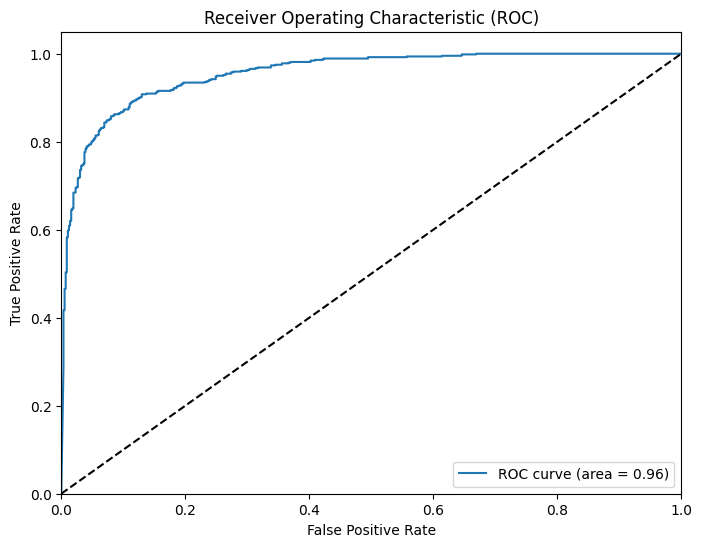

In [431]:
# roc accuracy and roc accuracy curve

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict probabilities for the positive class
y_pred_proba = gnb.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

PCA

In [432]:
# Scale numeric features
scaler = StandardScaler()
numeric_cols = X_res.select_dtypes(include=np.number).columns
X_res[numeric_cols] = scaler.fit_transform(X_res[numeric_cols])

In [433]:
# PCA for dimensionality reduction
pca = PCA(n_components=0.90)
X_pca = pca.fit_transform(X_res)
print(f"Number of components selected: {pca.n_components_}")


Number of components selected: 16


In [436]:
# Split the resampled dataset
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_res, test_size=0.2, random_state=42)

In [437]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
score = lr.score(X_train, y_train)
print(f'Score : {score : }')
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_lr)}")
print(classification_report(y_test, y_pred_lr))


Score :  0.9138755980861244
Logistic Regression Accuracy: 0.8943427620632279
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       562
           1       0.91      0.89      0.90       640

    accuracy                           0.89      1202
   macro avg       0.89      0.89      0.89      1202
weighted avg       0.89      0.89      0.89      1202



[[504  58]
 [ 69 571]]


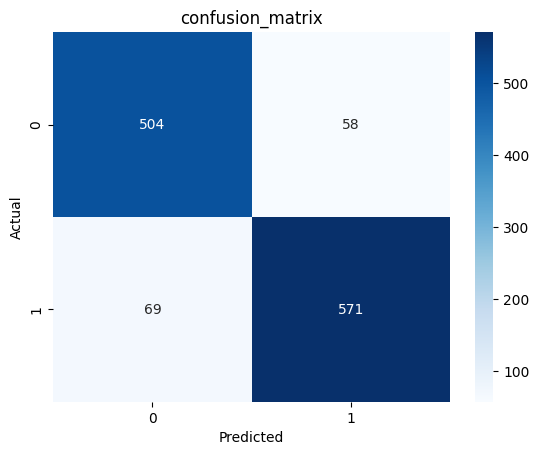

In [438]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_lr)
print(conf_matrix)
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues')
plt.title('confusion_matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

ROC AUC Score: 0.9679409475088967


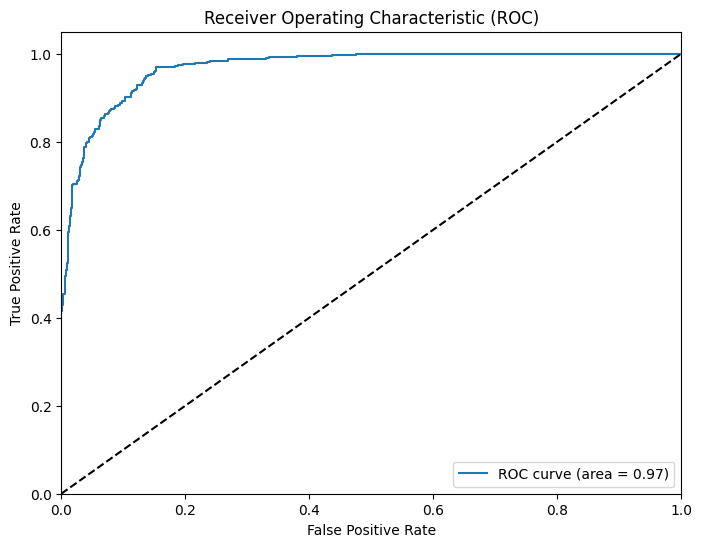

In [439]:
# roc accuracy and roc accuracy curve

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict probabilities for the positive class
y_pred_proba = lr.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [440]:
# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
score = rf.score(X_train, y_train)
print(f'Score : {score : }')
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(classification_report(y_test, y_pred_rf))

Score :  1.0
Random Forest Accuracy: 0.9417637271214643
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       562
           1       0.95      0.94      0.95       640

    accuracy                           0.94      1202
   macro avg       0.94      0.94      0.94      1202
weighted avg       0.94      0.94      0.94      1202



[[528  34]
 [ 36 604]]


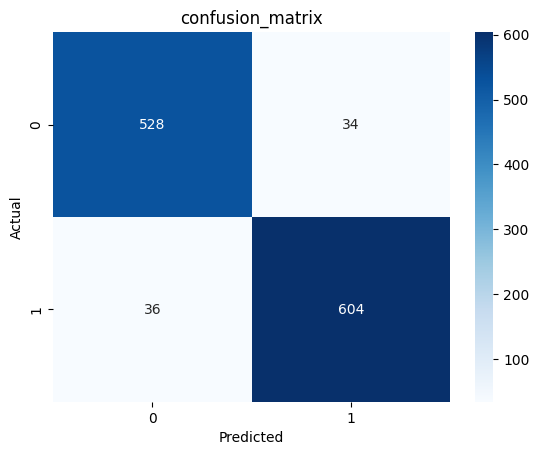

In [441]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)
print(conf_matrix)
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues')
plt.title('confusion_matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

ROC AUC Score: 0.9829195395907474


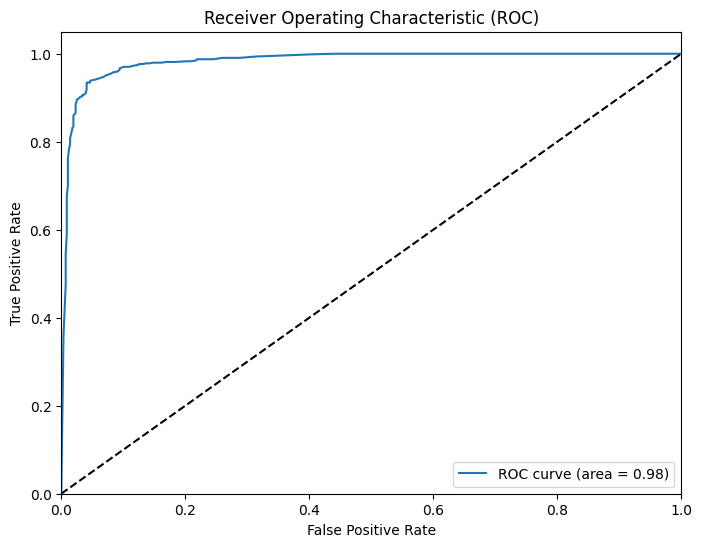

In [442]:
# roc accuracy and roc accuracy curve

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict probabilities for the positive class
y_pred_proba = rf.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [443]:
# XGBoost
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
score = xgb.score(X_train, y_train)
print(f'Score : {score : }')
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb)}")
print(classification_report(y_test, y_pred_xgb))

Score :  1.0
XGBoost Accuracy: 0.9384359400998337
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       562
           1       0.94      0.94      0.94       640

    accuracy                           0.94      1202
   macro avg       0.94      0.94      0.94      1202
weighted avg       0.94      0.94      0.94      1202



[[527  35]
 [ 39 601]]


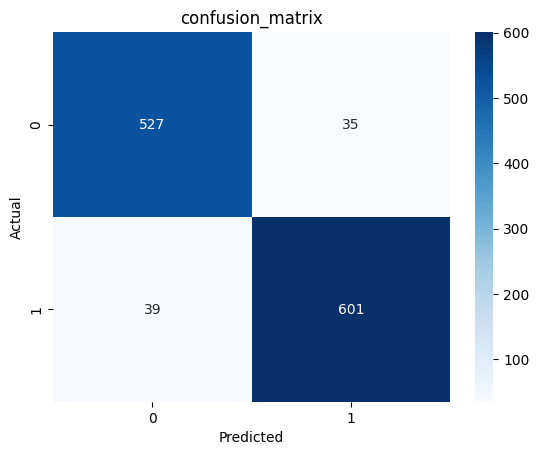

In [444]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
print(conf_matrix)
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues')
plt.title('confusion_matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

ROC AUC Score: 0.9853175044483985


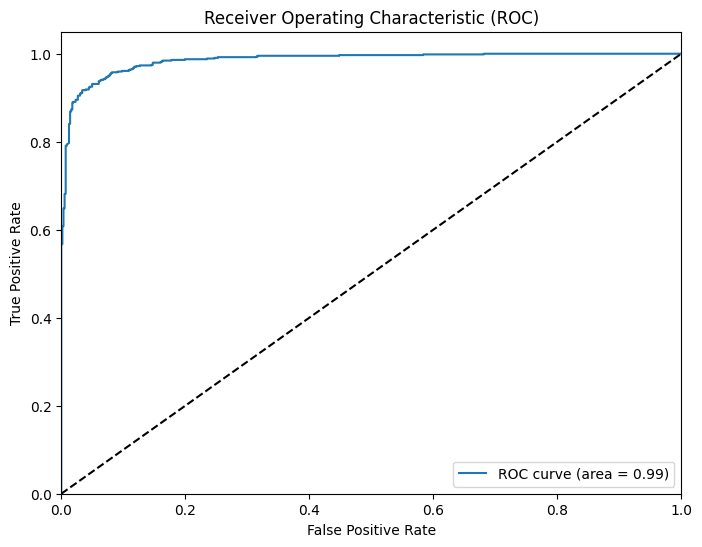

In [445]:
# roc accuracy and roc accuracy curve

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict probabilities for the positive class
y_pred_proba = xgb.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [448]:
# Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)
score = gnb.score(X_train, y_train)
print(f'Score : {score : }')
print(f"Naive Bayes Accuracy: {accuracy_score(y_test, y_pred_gnb)}")
print(classification_report(y_test, y_pred_gnb))

Score :  0.9078427293530268
Naive Bayes Accuracy: 0.9001663893510815
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       562
           1       0.92      0.89      0.90       640

    accuracy                           0.90      1202
   macro avg       0.90      0.90      0.90      1202
weighted avg       0.90      0.90      0.90      1202



[[515  47]
 [ 73 567]]


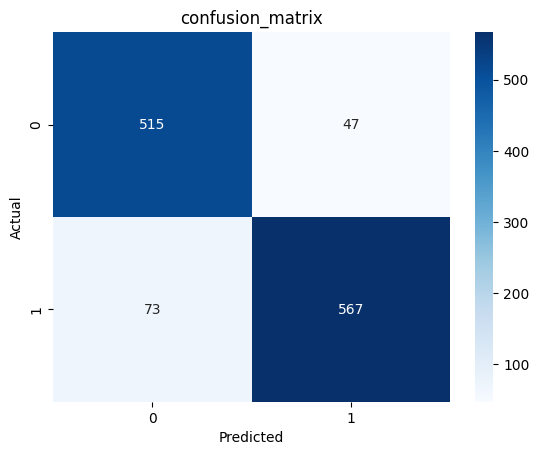

In [449]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_gnb)
print(conf_matrix)
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues')
plt.title('confusion_matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

ROC AUC Score: 0.9508702179715303


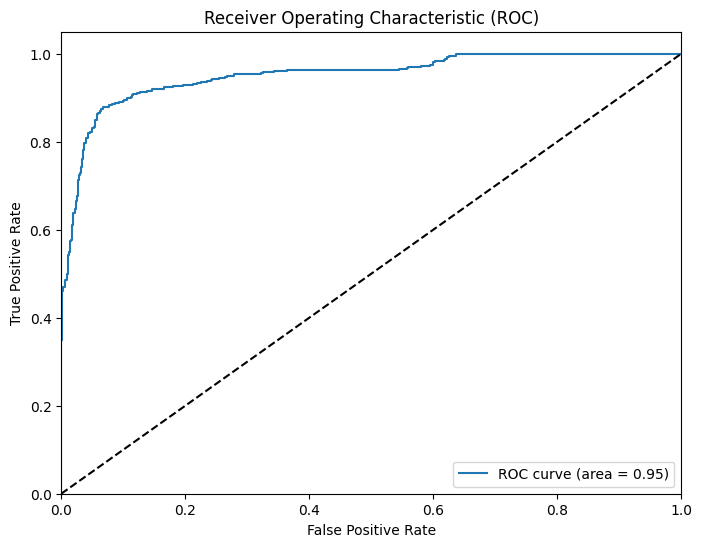

In [450]:
# roc accuracy and roc accuracy curve

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict probabilities for the positive class
y_pred_proba = gnb.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [451]:
# make a voting based ensemble that takes all results from made models and create a new y_test_pred with the most frequent result

import numpy as np
from scipy.stats import mode

# Combine predictions from all models
all_predictions = np.array([y_pred, y_pred_xgb, y_pred_rand, y_pred_gnb])

# Find the most frequent prediction for each instance
y_test_pred = mode(all_predictions, axis=0)[0]

In [452]:
y_test_pred

array([0, 1, 0, ..., 1, 0, 1])

In [453]:
# Evaluate the logistic regressin model
score = model.score(X_train, y_train)
print(f'Score : {score : }')
accuracy =  accuracy_score(y_test, y_pred)
print(f'Accuracy : {accuracy : }')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n",conf_matrix)

print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


ValueError: X has 16 features, but LogisticRegression is expecting 31 features as input.

In [61]:
# Evaluate the logistic regressin model
score = model.score(X_train, y_train)
print(f'Score : {score : }')
accuracy =  accuracy_score(y_test, y_pred_rand)
print(f'Accuracy : {accuracy : }')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_rand)
print("Confusion Matrix:\n",conf_matrix)

print(classification_report(y_test, y_pred_rand))

Score :  0.9448720615768671
Accuracy :  0.9442595673876872
Confusion Matrix:
 [[537  25]
 [ 42 598]]
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       562
           1       0.96      0.93      0.95       640

    accuracy                           0.94      1202
   macro avg       0.94      0.94      0.94      1202
weighted avg       0.94      0.94      0.94      1202



In [60]:
# Evaluate the logistic regressin model
score = model.score(X_train, y_train)
print(f'Score : {score : }')
accuracy =  accuracy_score(y_test, y_pred_xgb)
print(f'Accuracy : {accuracy : }')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix:\n",conf_matrix)

print(classification_report(y_test, y_pred_xgb))

Score :  0.9448720615768671
Accuracy :  0.9409317803660566
Confusion Matrix:
 [[533  29]
 [ 42 598]]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       562
           1       0.95      0.93      0.94       640

    accuracy                           0.94      1202
   macro avg       0.94      0.94      0.94      1202
weighted avg       0.94      0.94      0.94      1202



In [62]:
# Evaluate the logistic regressin model
score = model.score(X_train, y_train)
print(f'Score : {score : }')
accuracy =  accuracy_score(y_test, y_pred_gnb)
print(f'Accuracy : {accuracy : }')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_gnb)
print("Confusion Matrix:\n",conf_matrix)

print(classification_report(y_test, y_pred_gnb))

Score :  0.9448720615768671
Accuracy :  0.8835274542429284
Confusion Matrix:
 [[517  45]
 [ 95 545]]
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       562
           1       0.92      0.85      0.89       640

    accuracy                           0.88      1202
   macro avg       0.88      0.89      0.88      1202
weighted avg       0.89      0.88      0.88      1202



In [63]:
# fine tune with grid search

from sklearn.model_selection import GridSearchCV

# Define the parameter grid for RandomForestClassifier
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Use the best model for prediction
best_rf_model = grid_search.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)

# Evaluate the best model
accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
print("Accuracy of best Random Forest model:", accuracy_best_rf)
print(classification_report(y_test, y_pred_best_rf))


Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score: 0.9413383927431795
Accuracy of best Random Forest model: 0.9392678868552413
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       562
           1       0.95      0.94      0.94       640

    accuracy                           0.94      1202
   macro avg       0.94      0.94      0.94      1202
weighted avg       0.94      0.94      0.94      1202



In [64]:
# hyper pramater tuning for all models i used in

import numpy as np
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for Logistic Regression
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # Suitable for smaller datasets and L1 regularization
}
grid_search_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5, scoring='accuracy')
grid_search_lr.fit(X_train, y_train)
print("Best parameters for Logistic Regression:", grid_search_lr.best_params_)
print("Best score for Logistic Regression:", grid_search_lr.best_score_)


# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)
print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print("Best score for Random Forest:", grid_search_rf.best_score_)


# Hyperparameter tuning for XGBoost
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}
grid_search_xgb = GridSearchCV(XGBClassifier(), param_grid_xgb, cv=5, scoring='accuracy')
grid_search_xgb.fit(X_train, y_train)
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)
print("Best score for XGBoost:", grid_search_xgb.best_score_)


# Hyperparameter tuning for GaussianNB (limited options)
# param_grid_gnb = {
#     'var_smoothing': np.logspace(0,-9, num=100)
# }
# grid_search_gnb = GridSearchCV(GaussianNB(), param_grid_gnb, cv=5, scoring='accuracy')
# grid_search_gnb.fit(X_train, y_train)
# print("Best parameters for GaussianNB:", grid_search_gnb.best_params_)
# print("Best score for GaussianNB:", grid_search_gnb.best_score_)


Best parameters for Logistic Regression: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best score for Logistic Regression: 0.9467463941969665
Best parameters for Random Forest: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score for Random Forest: 0.941963391391071
Best parameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.9}
Best score for XGBoost: 0.9452904437295697


In [65]:
#  hyper pramater tuning for all models i used in random parameters make randn

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Hyperparameter tuning for Logistic Regression
param_dist_lr = {
    'C': uniform(loc=0.001, scale=100),  # Use uniform distribution for C
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
random_search_lr = RandomizedSearchCV(LogisticRegression(max_iter=1000), param_distributions=param_dist_lr, n_iter=20, cv=5, scoring='accuracy', random_state=42)
random_search_lr.fit(X_train, y_train)
print("Best parameters for Logistic Regression:", random_search_lr.best_params_)
print("Best score for Logistic Regression:", random_search_lr.best_score_)


# Hyperparameter tuning for Random Forest
param_dist_rf = {
    'n_estimators': randint(50, 200),  # Use randint for n_estimators
    'max_depth': [None, 10, 20, 30],  # You can add more values
    'min_samples_split': randint(2, 10),  # Use randint
    'min_samples_leaf': randint(1, 4),  # Use randint
    'criterion': ['gini', 'entropy']
}
random_search_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_dist_rf, n_iter=20, cv=5, scoring='accuracy', random_state=42)
random_search_rf.fit(X_train, y_train)
print("Best parameters for Random Forest:", random_search_rf.best_params_)
print("Best score for Random Forest:", random_search_rf.best_score_)


# Hyperparameter tuning for XGBoost
param_dist_xgb = {
    'learning_rate': uniform(loc=0.01, scale=0.2),  # Use uniform distribution
    'max_depth': randint(3, 10),  # Use randint
    'n_estimators': randint(50, 200),  # Use randint
    'subsample': uniform(loc=0.8, scale=0.2),  # Use uniform distribution
    'colsample_bytree': uniform(loc=0.8, scale=0.2)  # Use uniform distribution
}
random_search_xgb = RandomizedSearchCV(XGBClassifier(), param_distributions=param_dist_xgb, n_iter=20, cv=5, scoring='accuracy', random_state=42)
random_search_xgb.fit(X_train, y_train)
print("Best parameters for XGBoost:", random_search_xgb.best_params_)
print("Best score for XGBoost:", random_search_xgb.best_score_)


# Hyperparameter tuning for KNN
param_dist_knn = {
    'n_neighbors': randint(1, 20),  # Use randint for n_neighbors
    'weights': ['uniform', 'distance'],  # Options for weights
    'metric': ['euclidean', 'manhattan']  # Options for distance metric
}
random_search_knn = RandomizedSearchCV(KNeighborsClassifier(), param_distributions=param_dist_knn, n_iter=20, cv=5, scoring='accuracy', random_state=42)
random_search_knn.fit(X_train, y_train)
print("Best parameters for KNN:", random_search_knn.best_params_)
print("Best score for KNN:", random_search_knn.best_score_)

# Hyperparameter tuning for GaussianNB (limited options)
param_dist_gnb = {
    'var_smoothing': uniform(loc=1e-10, scale=1e-2)  # Use uniform distribution for var_smoothing
}
random_search_gnb = RandomizedSearchCV(GaussianNB(), param_distributions=param_dist_gnb, n_iter=20, cv=5, scoring='accuracy', random_state=42)
random_search_gnb.fit(X_train, y_train)
print("Best parameters for GaussianNB:", random_search_gnb.best_params_)
print("Best score for GaussianNB:", random_search_gnb.best_score_)


Best parameters for Logistic Regression: {'C': 59.86684841970366, 'penalty': 'l1', 'solver': 'liblinear'}
Best score for Logistic Regression: 0.9467463941969665
Best parameters for Random Forest: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 108}
Best score for Random Forest: 0.9417557075205358
Best parameters for XGBoost: {'colsample_bytree': 0.8285733635843882, 'learning_rate': 0.14017769458977059, 'max_depth': 7, 'n_estimators': 51, 'subsample': 0.944399754453365}
Best score for XGBoost: 0.9444597082474294
Best parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
Best score for KNN: 0.931976393266716
Best parameters for GaussianNB: {'var_smoothing': 0.008661761557749352}
Best score for GaussianNB: 0.8945329384455295


In [68]:
classifier = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

# Evaluate the model
score = classifier.score(X_train, y_train)
print(f'Score : {score : }')
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy : {accuracy : }')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

print(classification_report(y_test, y_pred))


Score :  0.969211566465571
Accuracy :  0.940099833610649
Confusion Matrix:
 [[529  33]
 [ 39 601]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       562
           1       0.95      0.94      0.94       640

    accuracy                           0.94      1202
   macro avg       0.94      0.94      0.94      1202
weighted avg       0.94      0.94      0.94      1202



new try Selected Feature Manually accyrracy increased

In [570]:
dataset = pd.read_csv('/content/Telecom Customers Churn.csv')
dataset.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [571]:
dataset = dataset.drop(['customerID'], axis=1)
dataset.head()

gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0              Yes           Electronic check           29.85        29.85   
1               No               Mailed check           56.95       1889.5   
2              Yes               Mailed check           53.85       108.15   
3               No  Bank transfer (automatic)           42.30      1840.75   
4              Yes           Electronic check           70.70       151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

In [544]:
# # Convert TotalCharges to float, replacing ' ' with NaN
# dataset['TotalCharges'] = pd.to_numeric(dataset['TotalCharges'], errors='coerce')

In [545]:
# all are new customers thats why it is empty as told by tenure column
# If there are still missing values after this step, use median imputation
# dataset['TotalCharges'] = dataset['TotalCharges'].fillna(dataset['TotalCharges'].mean())

In [546]:
# finding categorical columns again after removing numeric total charges and after label encoding

# df_cat=dataset.columns[dataset.dtypes=='O']
# df_cat

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object')

In [547]:
# dataset.head()

gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges  TotalCharges  \
0              Yes           Electronic check           29.85         29.85   
1               No               Mailed check           56.95       1889.50   
2              Yes               Mailed check           53.85        108.15   
3               No  Bank transfer (automatic)           42.30       1840.75   
4              Yes           Electronic check           70.70        151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

Feature Extraction

In [572]:
# Create an annual categorical variable from the variable Tenure

dataset.loc[(dataset["tenure"]>=0) & (dataset["tenure"]<=12),"NEW_TENURE_YEAR"] = "0-1 Year"
dataset.loc[(dataset["tenure"]>12) & (dataset["tenure"]<=24),"NEW_TENURE_YEAR"] = "1-2 Year"
dataset.loc[(dataset["tenure"]>24) & (dataset["tenure"]<=36),"NEW_TENURE_YEAR"] = "2-3 Year"
dataset.loc[(dataset["tenure"]>36) & (dataset["tenure"]<=48),"NEW_TENURE_YEAR"] = "3-4 Year"
dataset.loc[(dataset["tenure"]>48) & (dataset["tenure"]<=60),"NEW_TENURE_YEAR"] = "4-5 Year"
dataset.loc[(dataset["tenure"]>60) & (dataset["tenure"]<=72),"NEW_TENURE_YEAR"] = "5-6 Year"

In [573]:
# Specify customers with a 1 or 2 year contract as Engaged

dataset["NEW_Engaged"] = dataset["Contract"].apply(lambda x: 1 if x in ["One year","Two year"] else 0)

In [574]:
 # People who do not receive any support, backup or protection

dataset["NEW_noProt"] = dataset.apply(lambda x: 1 if (x["OnlineBackup"] != "Yes") or (x["DeviceProtection"] != "Yes") or (x["TechSupport"] != "Yes") else 0, axis=1)

In [575]:

# Young customers with a monthly contract

dataset["NEW_Young_Not_Engaged"] = dataset.apply(lambda x: 1 if (x["NEW_Engaged"] == 0) and (x["SeniorCitizen"] == 0) else 0, axis=1)

In [576]:
# Total number of services received by the person

dataset['NEW_TotalServices'] = (dataset[['PhoneService', 'InternetService', 'OnlineSecurity',
                                       'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                       'StreamingTV', 'StreamingMovies']]== 'Yes').sum(axis=1)

In [577]:
# People who receive any streaming service

dataset["NEW_FLAG_ANY_STREAMING"] = dataset.apply(lambda x: 1 if (x["StreamingTV"] == "Yes") or (x["StreamingMovies"] == "Yes") else 0, axis=1)

In [578]:
# Does the person make automatic payments?

dataset["NEW_FLAG_AutoPayment"] = dataset["PaymentMethod"].apply(lambda x: 1 if x in ["Bank transfer (automatic)","Credit card (automatic)"] else 0)

In [579]:
dataset = pd.DataFrame(dataset)

In [580]:
# Label ecoder on churn and contract
label_col = ['Churn', 'Contract']

# Convert categorical columns to numeric using LabelEncoder
label_encoder = {}
for column in label_col :
    label = LabelEncoder()
    dataset[column] = label.fit_transform(dataset[column])
    label_encoder[column] = label
dataset.head()

gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  ...  \
0  No phone service             DSL             No          Yes  ...   
1                No             DSL            Yes           No  ...   
2                No             DSL            Yes          Yes  ...   
3  No phone service             DSL            Yes           No  ...   
4                No     Fiber optic             No           No  ...   

  MonthlyCharges TotalCharges Churn NEW_TENURE_YEAR  NEW_Engaged NEW_noProt  \
0          29.85        29.85     0        0-1 Year            0          1   
1          56.95       1889.5     0        2-3 Year            1          1   
2          53.85       108.15     1        0-1 Year            0          1   
3          42.30      1840.75     0        3-4 Year            1          1   
4          70.70       151.65     1        0-1 Year            0          1   

  NEW_Young_Not_Engaged  NEW_TotalServices NEW_FLAG_ANY_STREAMING  \
0                     1                  1                      0   
1                     0                  3                      0   
2                     1                  3                      0   
3                     0                  3                      0   
4                     1                  1                      0   

   NEW_FLAG_AutoPayment  
0                     0  
1                     0  
2                     0  
3                     1  
4                     0  

[5 rows x 27 columns]

In [581]:
# getting Categorical Data

df_cat = dataset.columns[dataset.dtypes == 'O']
df_cat

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling',
       'PaymentMethod', 'TotalCharges', 'NEW_TENURE_YEAR'],
      dtype='object')

In [582]:
# getting numeric columns

# df_num = dataset.columns[dataset.dtypes != 'O']
df_num=dataset.columns[dataset.dtypes!='O'].tolist()
df_num

['SeniorCitizen',
 'tenure',
 'Contract',
 'MonthlyCharges',
 'Churn',
 'NEW_Engaged',
 'NEW_noProt',
 'NEW_Young_Not_Engaged',
 'NEW_TotalServices',
 'NEW_FLAG_ANY_STREAMING',
 'NEW_FLAG_AutoPayment']

In [583]:
df_num.append('TotalCharges')
df_num

['SeniorCitizen',
 'tenure',
 'Contract',
 'MonthlyCharges',
 'Churn',
 'NEW_Engaged',
 'NEW_noProt',
 'NEW_Young_Not_Engaged',
 'NEW_TotalServices',
 'NEW_FLAG_ANY_STREAMING',
 'NEW_FLAG_AutoPayment',
 'TotalCharges']

In [584]:
# Convert TotalCharges to float, replacing ' ' with NaN
dataset['TotalCharges'] = pd.to_numeric(dataset['TotalCharges'], errors='coerce')

In [585]:
# all are new customers thats why it is empty as told by tenure column
# If there are still missing values after this step, use median imputation
dataset['TotalCharges'] = dataset['TotalCharges'].fillna(dataset['TotalCharges'].mean())

In [586]:
# finding categorical columns again after removing numeric total charges and after label encoding

df_cat=dataset.columns[dataset.dtypes=='O']
df_cat

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling',
       'PaymentMethod', 'NEW_TENURE_YEAR'],
      dtype='object')

In [587]:
# one hot encoding of categorical columns

from sklearn.preprocessing import OneHotEncoder


encoder = OneHotEncoder(sparse=False)

encoded_data = encoder.fit_transform(dataset[df_cat])

encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out())

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [588]:
# removing old and joining new columns

dataset = pd.concat([dataset, pd.get_dummies(dataset[df_cat])], axis=1)

dataset = dataset.drop(df_cat, axis=1)

In [589]:
# average monthly payment

dataset["NEW_AVG_Charges"] = dataset["TotalCharges"] / (dataset["tenure"] + 1)

In [590]:
# Increase in current price compared to average price

dataset["NEW_Increase"] = dataset["NEW_AVG_Charges"] / dataset["MonthlyCharges"]

In [591]:
# Fee per service

dataset["NEW_AVG_Service_Fee"] = dataset["MonthlyCharges"] / (dataset['NEW_TotalServices'] + 1)

In [592]:
dataset.head()

SeniorCitizen  tenure  Contract  MonthlyCharges  TotalCharges  Churn  \
0              0       1         0           29.85         29.85      0   
1              0      34         1           56.95       1889.50      0   
2              0       2         0           53.85        108.15      1   
3              0      45         1           42.30       1840.75      0   
4              0       2         0           70.70        151.65      1   

   NEW_Engaged  NEW_noProt  NEW_Young_Not_Engaged  NEW_TotalServices  ...  \
0            0           1                      1                  1  ...   
1            1           1                      0                  3  ...   
2            0           1                      1                  3  ...   
3            1           1                      0                  3  ...   
4            0           1                      1                  1  ...   

   PaymentMethod_Mailed check  NEW_TENURE_YEAR_0-1 Year  \
0                       False                      True   
1                        True                     False   
2                        True                      True   
3                       False                     False   
4                       False                      True   

   NEW_TENURE_YEAR_1-2 Year  NEW_TENURE_YEAR_2-3 Year  \
0                     False                     False   
1                     False                      True   
2                     False                     False   
3                     False                     False   
4                     False                     False   

   NEW_TENURE_YEAR_3-4 Year  NEW_TENURE_YEAR_4-5 Year  \
0                     False                     False   
1                     False                     False   
2                     False                     False   
3                      True                     False   
4                     False                     False   

   NEW_TENURE_YEAR_5-6 Year  NEW_AVG_Charges  NEW_Increase  \
0                     False        14.925000      0.500000   
1                     False        53.985714      0.947949   
2                     False        36.050000      0.669452   
3                     False        40.016304      0.946012   
4                     False        50.550000      0.714993   

   NEW_AVG_Service_Fee  
0              14.9250  
1              14.2375  
2              13.4625  
3              10.5750  
4              35.3500  

[5 rows x 59 columns]

In [528]:
# # Label ecoder on churn and contract
# label_col = ['Churn', 'Contract']

# # Convert categorical columns to numeric using LabelEncoder
# label_encoder = {}
# for column in label_col :
#     label = LabelEncoder()
#     dataset[column] = label.fit_transform(dataset[column])
#     label_encoder[column] = label
# dataset.head()

gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  ...  \
0  No phone service             DSL             No          Yes  ...   
1                No             DSL            Yes           No  ...   
2                No             DSL            Yes          Yes  ...   
3  No phone service             DSL            Yes           No  ...   
4                No     Fiber optic             No           No  ...   

  NEW_TENURE_YEAR NEW_Engaged NEW_noProt NEW_Young_Not_Engaged  \
0        0-1 Year           0          1                     1   
1        2-3 Year           1          1                     0   
2        0-1 Year           0          1                     1   
3        3-4 Year           1          1                     0   
4        0-1 Year           0          1                     1   

   NEW_TotalServices NEW_FLAG_ANY_STREAMING NEW_FLAG_AutoPayment  \
0                  1                      0                    0   
1                  3                      0                    0   
2                  3                      0                    0   
3                  3                      0                    1   
4                  1                      0                    0   

   NEW_AVG_Service_Fee  NEW_AVG_Charges  NEW_Increase  
0              14.9250        14.925000      0.500000  
1              14.2375        53.985714      0.947949  
2              13.4625        36.050000      0.669452  
3              10.5750        40.016304      0.946012  
4              35.3500        50.550000      0.714993  

[5 rows x 30 columns]

In [566]:
# # one hot encoding of categorical columns

# from sklearn.preprocessing import OneHotEncoder


# encoder = OneHotEncoder(sparse=False)

# encoded_data = encoder.fit_transform(dataset[df_cat])

# encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out())

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [567]:
# # removing old and joining new columns

# dataset = pd.concat([dataset, pd.get_dummies(dataset[df_cat])], axis=1)

# dataset = dataset.drop(df_cat, axis=1)

In [568]:
dataset.head()

SeniorCitizen  tenure  MonthlyCharges  TotalCharges NEW_TENURE_YEAR  \
0              0       1           29.85         29.85        0-1 Year   
1              0      34           56.95       1889.50        2-3 Year   
2              0       2           53.85        108.15        0-1 Year   
3              0      45           42.30       1840.75        3-4 Year   
4              0       2           70.70        151.65        0-1 Year   

   NEW_Engaged  NEW_noProt  NEW_Young_Not_Engaged  NEW_TotalServices  \
0            0           1                      1                  1   
1            1           1                      0                  3   
2            0           1                      1                  3   
3            1           1                      0                  3   
4            0           1                      1                  1   

   NEW_FLAG_ANY_STREAMING  ...  StreamingTV_Yes  StreamingMovies_No  \
0                       0  ...            False                True   
1                       0  ...            False                True   
2                       0  ...            False                True   
3                       0  ...            False                True   
4                       0  ...            False                True   

   StreamingMovies_No internet service  StreamingMovies_Yes  \
0                                False                False   
1                                False                False   
2                                False                False   
3                                False                False   
4                                False                False   

   PaperlessBilling_No  PaperlessBilling_Yes  \
0                False                  True   
1                 True                 False   
2                False                  True   
3                 True                 False   
4                False                  True   

   PaymentMethod_Bank transfer (automatic)  \
0                                    False   
1                                    False   
2                                    False   
3                                     True   
4                                    False   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                  False                            True   
1                                  False                           False   
2                                  False                           False   
3                                  False                           False   
4                                  False                            True   

   PaymentMethod_Mailed check  
0                       False  
1                        True  
2                        True  
3                       False  
4                       False  

[5 rows x 52 columns]

In [593]:
# senior citizens are not numeric it should not be in it

df_num.remove('SeniorCitizen')
df_num.remove('Churn')

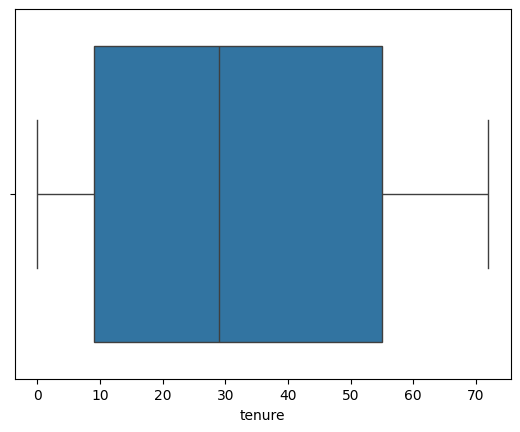

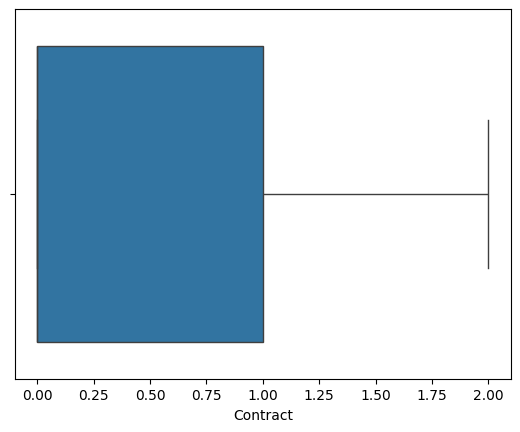

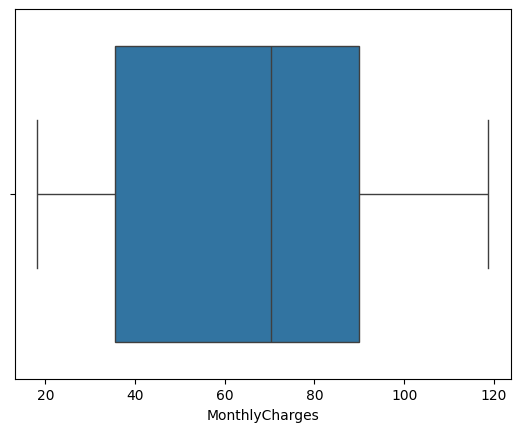

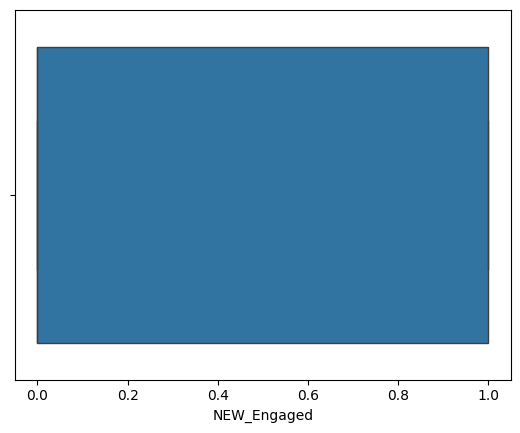

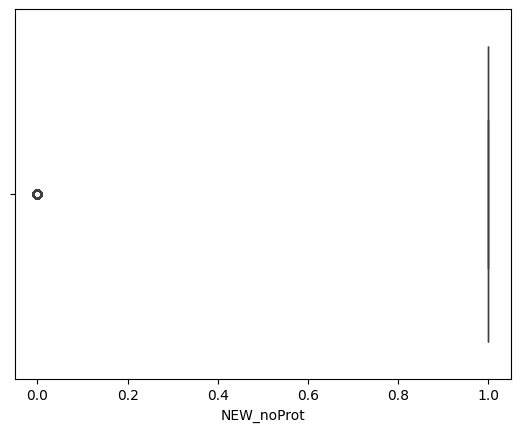

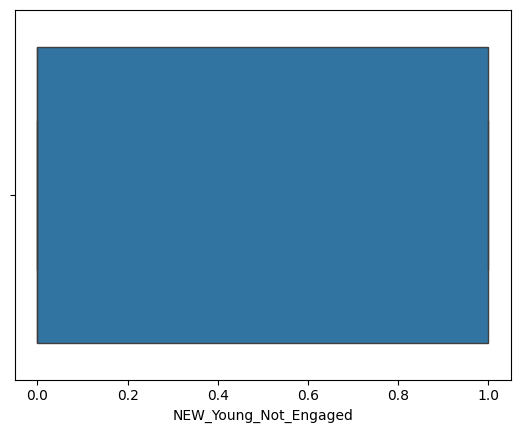

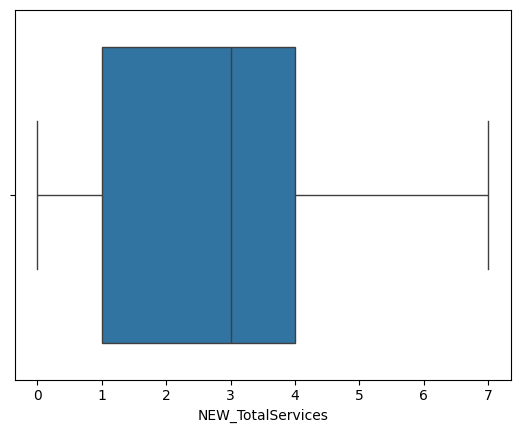

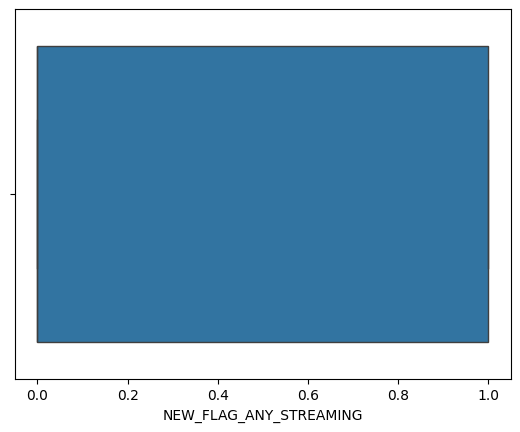

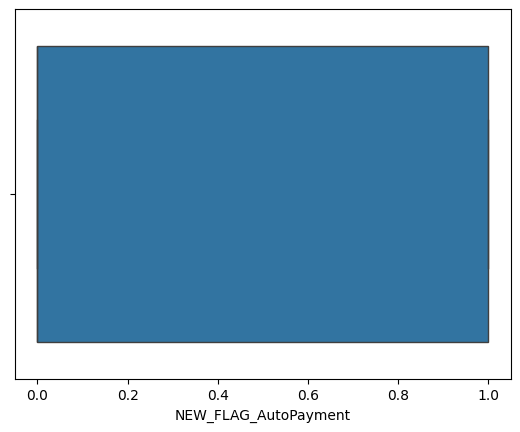

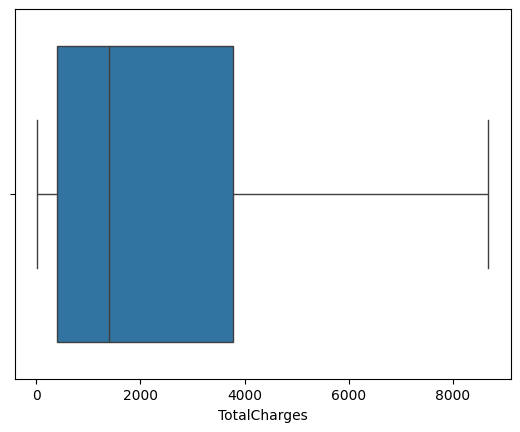

In [594]:
# visualizing outliers by box plot

for i in df_num:
    sns.boxplot(x=dataset[i])
    plt.show()

In [595]:
# Detecting outliers

def detect_outliers_iqr(series):
  q1, q3 = series.quantile([0.25, 0.75])
  iqr = q3 - q1
  lower_bound = q1 - 1.5 * iqr
  upper_bound = q3 + 1.5 * iqr
  return series[(series < lower_bound) | (series > upper_bound)]


for i in df_num:
    print(detect_outliers_iqr(dataset[i]))

Series([], Name: tenure, dtype: int64)
Series([], Name: Contract, dtype: int64)
Series([], Name: MonthlyCharges, dtype: float64)
Series([], Name: NEW_Engaged, dtype: int64)
15      0
28      0
30      0
32      0
43      0
       ..
6982    0
6983    0
6995    0
7007    0
7036    0
Name: NEW_noProt, Length: 726, dtype: int64
Series([], Name: NEW_Young_Not_Engaged, dtype: int64)
Series([], Name: NEW_TotalServices, dtype: int64)
Series([], Name: NEW_FLAG_ANY_STREAMING, dtype: int64)
Series([], Name: NEW_FLAG_AutoPayment, dtype: int64)
Series([], Name: TotalCharges, dtype: float64)


In [596]:
# checking skewness of numeric data

for i in df_num:
    print(i,':',dataset[i].skew())

tenure : 0.2395397495619829
Contract : 0.6309590983751753
MonthlyCharges : -0.22052443394398033
NEW_Engaged : 0.20182896084395924
NEW_noProt : -2.611308928710584
NEW_Young_Not_Engaged : 0.25977870838781025
NEW_TotalServices : 0.48675074729959406
NEW_FLAG_ANY_STREAMING : 0.01278162866514697
NEW_FLAG_AutoPayment : 0.260943820397233
TotalCharges : 0.9623940229874866


In [597]:
# Split dataset into features (X) and target (y)
X = dataset.drop('Churn', axis=1)
y = dataset['Churn']


In [598]:
# Apply SMOTEENN for both oversampling and cleaning
smote_enn = SMOTEENN(random_state=42)
X_res, y_res = smote_enn.fit_resample(X, y)

df = pd.concat([X_res, y_res], axis=1)

print(pd.Series(y_res).value_counts())

Churn
1    3325
0    2723
Name: count, dtype: int64


In [599]:
# scaling columns using standard scaler

cols_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges',
                 'NEW_Increase', 'NEW_AVG_Charges', 'NEW_AVG_Service_Fee'

                 ]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])


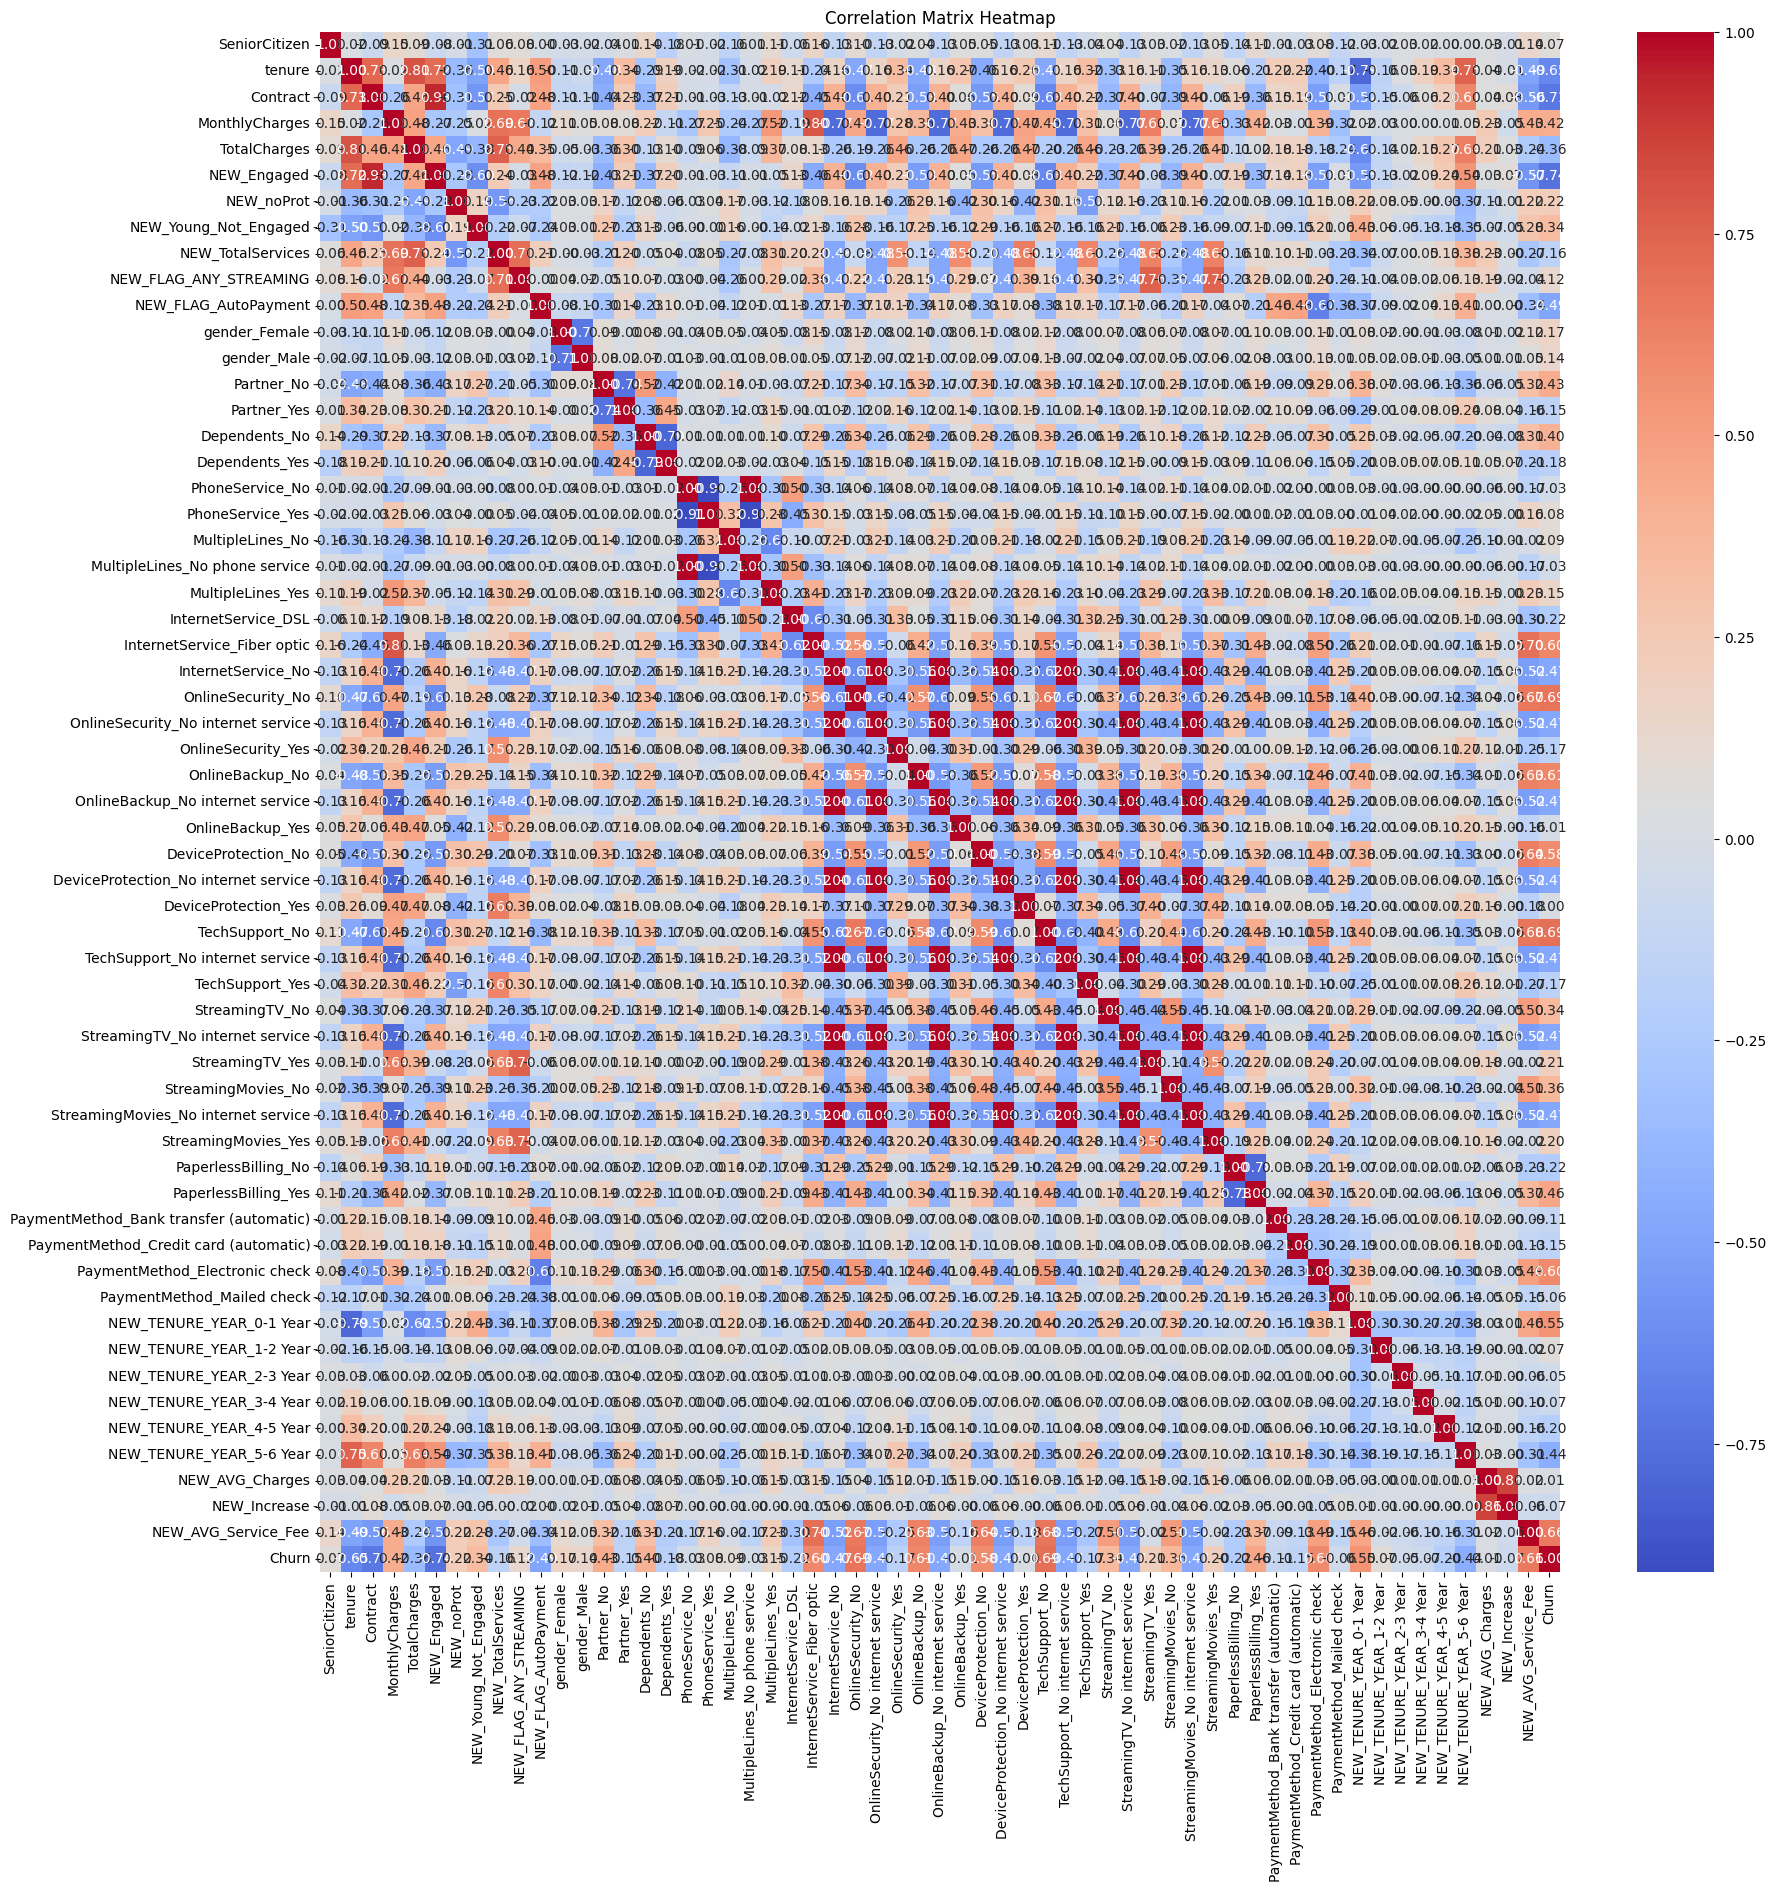

In [600]:
# visualizing the corr between the faetures
corr_matrix = df.corr()

plt.figure(figsize = (20, 20))
sns.heatmap(corr_matrix, annot = True, fmt = '.2f', cmap = 'coolwarm', cbar = True)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [601]:
# features that are highly correlated with the target variable
corr_with_target = corr_matrix['Churn'].sort_values(ascending = False)
print(corr_with_target)

Churn                                      1.000000
TechSupport_No                             0.694761
OnlineSecurity_No                          0.685967
NEW_AVG_Service_Fee                        0.658108
OnlineBackup_No                            0.610082
InternetService_Fiber optic                0.601845
PaymentMethod_Electronic check             0.596583
DeviceProtection_No                        0.581008
NEW_TENURE_YEAR_0-1 Year                   0.550814
PaperlessBilling_Yes                       0.462372
Partner_No                                 0.430013
MonthlyCharges                             0.418700
Dependents_No                              0.401821
StreamingMovies_No                         0.359222
StreamingTV_No                             0.343934
NEW_Young_Not_Engaged                      0.338929
NEW_noProt                                 0.220836
StreamingTV_Yes                            0.206686
StreamingMovies_Yes                        0.198638
gender_Femal

In [602]:
X.columns

Index(['SeniorCitizen', 'tenure', 'Contract', 'MonthlyCharges', 'TotalCharges',
       'NEW_Engaged', 'NEW_noProt', 'NEW_Young_Not_Engaged',
       'NEW_TotalServices', 'NEW_FLAG_ANY_STREAMING', 'NEW_FLAG_AutoPayment',
       'gender_Female', 'gender_Male', 'Partner_No', 'Partner_Yes',
       'Dependents_No', 'Dependents_Yes', 'PhoneService_No',
       'PhoneService_Yes', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_

In [603]:
selected_features = [
    'TechSupport_No',
    'OnlineSecurity_No' ,
    'NEW_AVG_Service_Fee' ,
    'InternetService_Fiber optic' ,
    'PaymentMethod_Electronic check' ,
    'NEW_Engaged' ,
    'Contract' ,
    'tenure' ,
    'NEW_FLAG_AutoPayment',
    'TotalCharges'
]

In [607]:
# Split the data
X = df[selected_features]
y = df['Churn']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=42)

In [604]:
# using logistic regression to know how well steps works

model = LogisticRegression(max_iter=1000)

# Train the model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# score
score = model.score(X_train, y_train)
print(f'Score : {score : }')
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


# Classification Report
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_rep)

Score :  0.9303692816461511
Accuracy: 0.9256198347107438
Confusion Matrix:
 [[259  25]
 [ 20 301]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92       284
           1       0.92      0.94      0.93       321

    accuracy                           0.93       605
   macro avg       0.93      0.92      0.93       605
weighted avg       0.93      0.93      0.93       605



In [608]:
# score
score = model.score(X_train, y_train)
print(f'Score : {score : }')
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Classification Report
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_rep)

Score :  0.9303692816461511
Accuracy: 0.9256198347107438
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92       284
           1       0.92      0.94      0.93       321

    accuracy                           0.93       605
   macro avg       0.93      0.92      0.93       605
weighted avg       0.93      0.93      0.93       605



[[259  25]
 [ 20 301]]


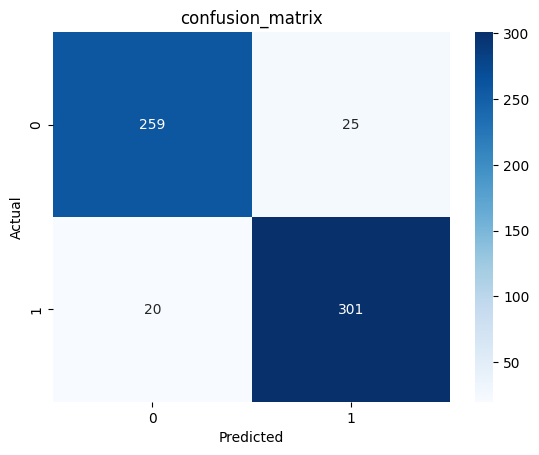

In [609]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues')
plt.title('confusion_matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

ROC AUC Score: 0.9784344697468298


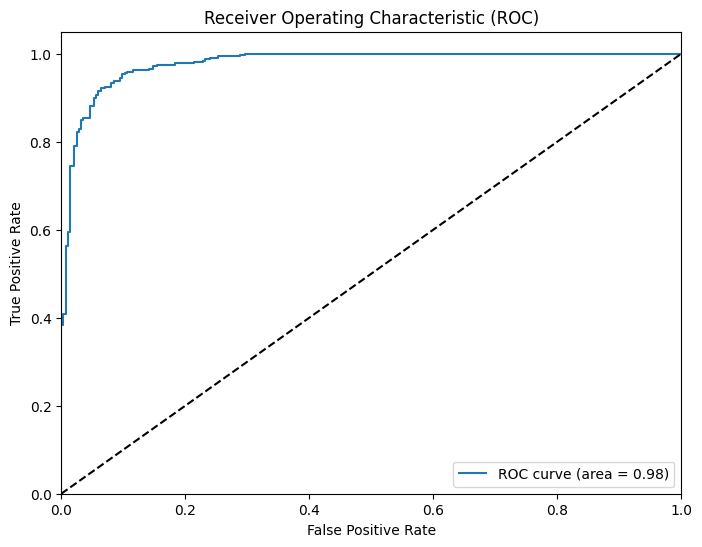

In [610]:
# roc accuracy and roc accuracy curve

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict probabilities for the positive class
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [611]:
# Initialize and train the RandomForest model
random = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 150)   # Random_state = 2 is the best
random.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rand = random.predict(X_test)

In [612]:
# Evaluate the model
score = random.score(X_train, y_train)
print(f'Score : {score : }')
accuracy =  accuracy_score(y_test, y_pred_rand)
print(f'Accuracy : {accuracy : }')


print(classification_report(y_test, y_pred_rand))

Score :  0.9998162777879845
Accuracy :  0.9586776859504132
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       284
           1       0.96      0.97      0.96       321

    accuracy                           0.96       605
   macro avg       0.96      0.96      0.96       605
weighted avg       0.96      0.96      0.96       605



[[270  14]
 [ 11 310]]


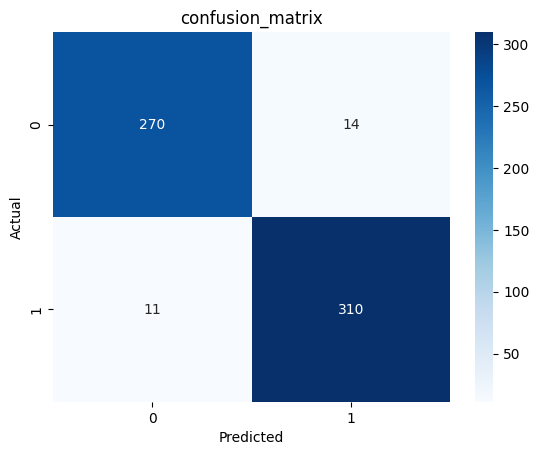

In [613]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_rand)
print(conf_matrix)
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues')
plt.title('confusion_matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# random_state = 42
# Score :  1.0
# Accuracy :  0.9434276206322796
# Confusion Matrix:
#  [[533  29]
#  [ 39 601]]
#               precision    recall  f1-score   support

#            0       0.93      0.95      0.94       562
#            1       0.95      0.94      0.95       640

#     accuracy                           0.94      1202
#    macro avg       0.94      0.94      0.94      1202
# weighted avg       0.94      0.94      0.94      1202

ROC AUC Score: 0.9908132596200254


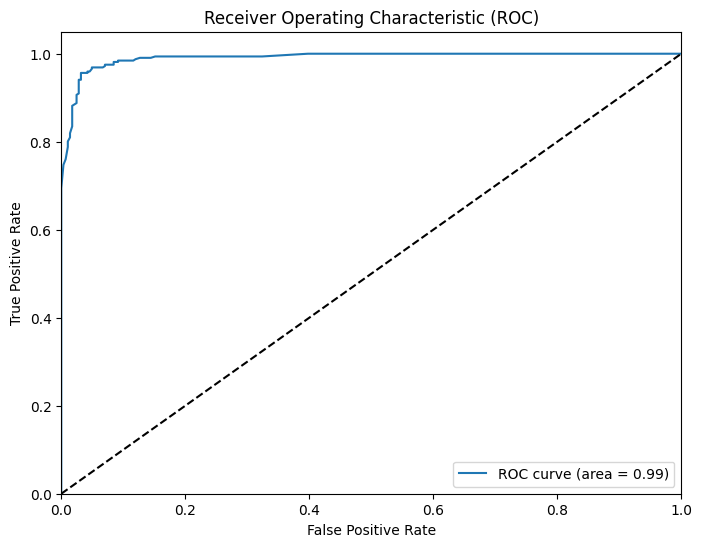

In [614]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict probabilities for the positive class
y_pred_proba = random.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [615]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

In [616]:
# Evaluate the model
score = xgb.score(X_train, y_train)
print(f'Score : {score : }')
accuracy =  accuracy_score(y_test, y_pred_xgb)
print(f'Accuracy : {accuracy : }')



print(classification_report(y_test, y_pred_xgb))

Score :  0.9939371670034908
Accuracy :  0.9603305785123967
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       284
           1       0.95      0.97      0.96       321

    accuracy                           0.96       605
   macro avg       0.96      0.96      0.96       605
weighted avg       0.96      0.96      0.96       605



[[269  15]
 [  9 312]]


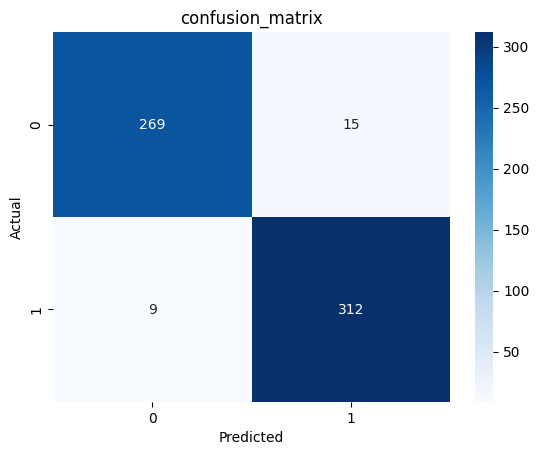

In [617]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
print(conf_matrix)
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues')
plt.title('confusion_matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Score :  0.9993759101310589
# Accuracy :  0.9409317803660566
# Confusion Matrix:
#  [[533  29]
#  [ 42 598]]
#               precision    recall  f1-score   support

#            0       0.93      0.95      0.94       562
#            1       0.95      0.93      0.94       640

#     accuracy                           0.94      1202
#    macro avg       0.94      0.94      0.94      1202
# weighted avg       0.94      0.94      0.94      1202


ROC AUC Score: 0.9917950068009302


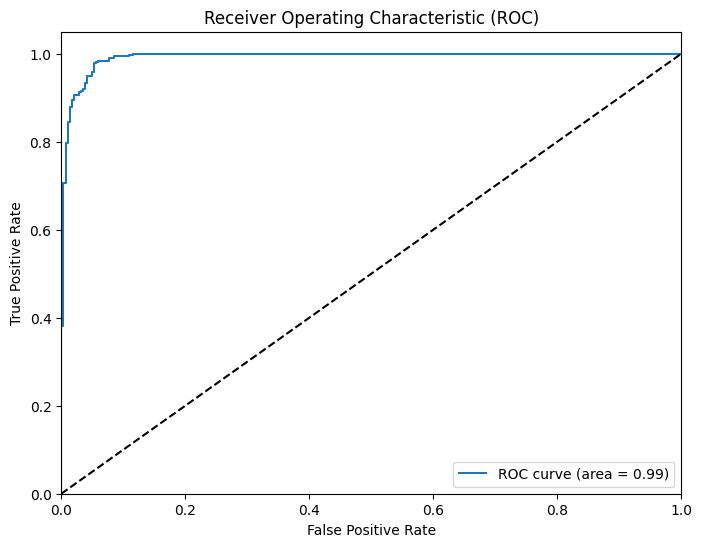

In [618]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict probabilities for the positive class
y_pred_proba = xgb.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [619]:
# Initialize and train the GaussianNB model
gnb = GaussianNB()
gnb.fit(X_train, y_train)
# Predict on the test set
y_pred_gnb = gnb.predict(X_test)

In [620]:
# Evaluate the model
score = gnb.score(X_train, y_train)
print(f'Score : {score : }')
accuracy =  accuracy_score(y_test, y_pred)
print(f'Accuracy : {accuracy : }')

print(classification_report(y_test, y_pred_gnb))

Score :  0.911262171596546
Accuracy :  0.9256198347107438
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       284
           1       0.91      0.94      0.93       321

    accuracy                           0.92       605
   macro avg       0.92      0.92      0.92       605
weighted avg       0.92      0.92      0.92       605



[[255  29]
 [ 19 302]]


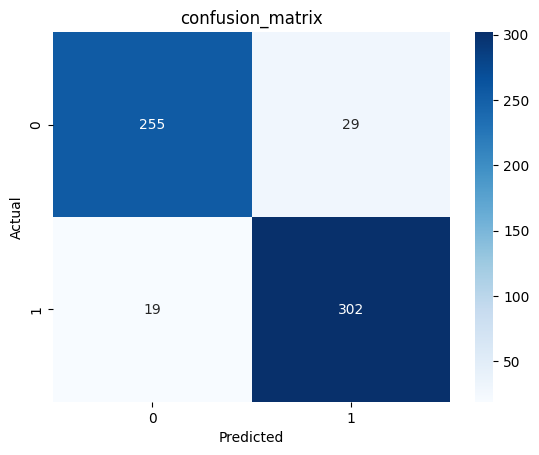

In [621]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_gnb)
print(conf_matrix)
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues')
plt.title('confusion_matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

ROC AUC Score: 0.9647667939098767


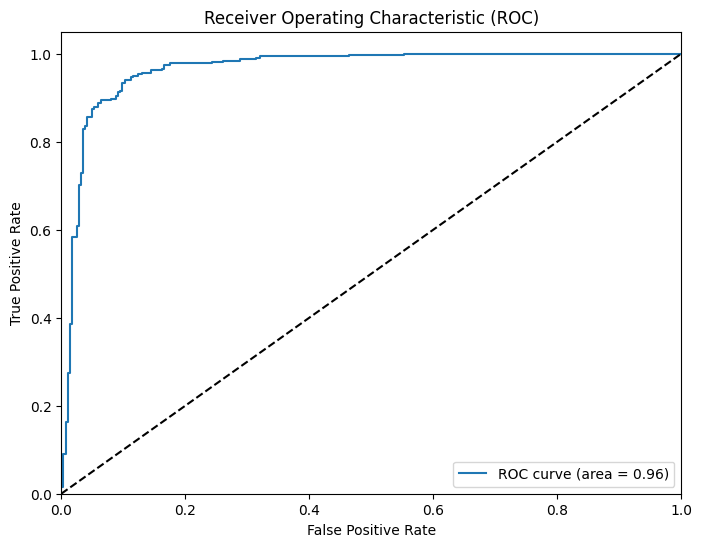

In [622]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict probabilities for the positive class
y_pred_proba = gnb.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

Fine tuning

In [623]:
# prompt: make a voting based ensemble that takes all results from made models and create a new y_test_pred with the most frequent result

import numpy as np
from scipy.stats import mode

# Combine predictions from all models
all_predictions = np.array([y_pred, y_pred_xgb, y_pred_rand, y_pred_gnb])

# Find the most frequent prediction for each instance
y_test_pred = mode(all_predictions, axis=0)[0]

In [624]:
y_test_pred

array([1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,

In [625]:
# Evaluate the logistic regressin model
score = model.score(X_train, y_train)
print(f'Score : {score : }')
accuracy =  accuracy_score(y_test, y_pred)
print(f'Accuracy : {accuracy : }')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n",conf_matrix)

print(classification_report(y_test, y_pred))

Score :  0.9303692816461511
Accuracy :  0.9256198347107438
Confusion Matrix:
 [[259  25]
 [ 20 301]]
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       284
           1       0.92      0.94      0.93       321

    accuracy                           0.93       605
   macro avg       0.93      0.92      0.93       605
weighted avg       0.93      0.93      0.93       605



In [626]:
# Evaluate the logistic regressin model
score = random.score(X_train, y_train)
print(f'Score : {score : }')
accuracy =  accuracy_score(y_test, y_pred_rand)
print(f'Accuracy : {accuracy : }')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_rand)
print("Confusion Matrix:\n",conf_matrix)

print(classification_report(y_test, y_pred_rand))

Score :  0.9998162777879845
Accuracy :  0.9586776859504132
Confusion Matrix:
 [[270  14]
 [ 11 310]]
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       284
           1       0.96      0.97      0.96       321

    accuracy                           0.96       605
   macro avg       0.96      0.96      0.96       605
weighted avg       0.96      0.96      0.96       605



In [627]:
# Evaluate the logistic regressin model
score = xgb.score(X_train, y_train)
print(f'Score : {score : }')
accuracy =  accuracy_score(y_test, y_pred_xgb)
print(f'Accuracy : {accuracy : }')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix:\n",conf_matrix)

print(classification_report(y_test, y_pred_xgb))

Score :  0.9939371670034908
Accuracy :  0.9603305785123967
Confusion Matrix:
 [[269  15]
 [  9 312]]
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       284
           1       0.95      0.97      0.96       321

    accuracy                           0.96       605
   macro avg       0.96      0.96      0.96       605
weighted avg       0.96      0.96      0.96       605



In [628]:
# Evaluate the logistic regressin model
score = gnb.score(X_train, y_train)
print(f'Score : {score : }')
accuracy =  accuracy_score(y_test, y_pred_gnb)
print(f'Accuracy : {accuracy : }')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_gnb)
print("Confusion Matrix:\n",conf_matrix)

print(classification_report(y_test, y_pred_gnb))

Score :  0.911262171596546
Accuracy :  0.9206611570247933
Confusion Matrix:
 [[255  29]
 [ 19 302]]
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       284
           1       0.91      0.94      0.93       321

    accuracy                           0.92       605
   macro avg       0.92      0.92      0.92       605
weighted avg       0.92      0.92      0.92       605



In [ ]:
# prompt: fine tune with grid search

from sklearn.model_selection import GridSearchCV

# Define the parameter grid for RandomForestClassifier
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Use the best model for prediction
best_rf_model = grid_search.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)

# Evaluate the best model
accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
print("Accuracy of best Random Forest model:", accuracy_best_rf)
print(classification_report(y_test, y_pred_best_rf))


Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best score: 0.9514455425608672
Accuracy of best Random Forest model: 0.9541359541359541
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       558
           1       0.95      0.97      0.96       663

    accuracy                           0.95      1221
   macro avg       0.96      0.95      0.95      1221
weighted avg       0.95      0.95      0.95      1221



In [ ]:
# prompt: hyper pramater tuning for all models i used in

import numpy as np
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for Logistic Regression
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # Suitable for smaller datasets and L1 regularization
}
grid_search_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5, scoring='accuracy')
grid_search_lr.fit(X_train, y_train)
print("Best parameters for Logistic Regression:", grid_search_lr.best_params_)
print("Best score for Logistic Regression:", grid_search_lr.best_score_)


# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)
print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print("Best score for Random Forest:", grid_search_rf.best_score_)


# Hyperparameter tuning for XGBoost
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}
grid_search_xgb = GridSearchCV(XGBClassifier(), param_grid_xgb, cv=5, scoring='accuracy')
grid_search_xgb.fit(X_train, y_train)
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)
print("Best score for XGBoost:", grid_search_xgb.best_score_)


# Hyperparameter tuning for GaussianNB (limited options)
# param_grid_gnb = {
#     'var_smoothing': np.logspace(0,-9, num=100)
# }
# grid_search_gnb = GridSearchCV(GaussianNB(), param_grid_gnb, cv=5, scoring='accuracy')
# grid_search_gnb.fit(X_train, y_train)
# print("Best parameters for GaussianNB:", grid_search_gnb.best_params_)
# print("Best score for GaussianNB:", grid_search_gnb.best_score_)


Best parameters for Logistic Regression: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best score for Logistic Regression: 0.9481674832625803
Best parameters for Random Forest: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best score for Random Forest: 0.9514455425608672
Best parameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Best score for XGBoost: 0.9553381462154136


In [ ]:
# prompt: fine tuning gridsearch random values randn for logistic regression

# Hyperparameter tuning for Logistic Regression with random values
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

param_dist_lr = {
    'C': uniform(loc=0.001, scale=100),  # Uniform distribution for C
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

random_search_lr = RandomizedSearchCV(
    LogisticRegression(max_iter=1000),
    param_distributions=param_dist_lr,
    n_iter=20,  # Number of random combinations to try
    cv=5,
    scoring='accuracy',
    random_state=42
)
random_search_lr.fit(X_train, y_train)
print("Best parameters for Logistic Regression (Random Search):", random_search_lr.best_params_)
print("Best score for Logistic Regression (Random Search):", random_search_lr.best_score_)


Best parameters for Logistic Regression (Random Search): {'C': 18.34447898661638, 'penalty': 'l2', 'solver': 'liblinear'}
Best score for Logistic Regression (Random Search): 0.9485768998439518


In [ ]:
# Look Here
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Function to generate random hyperparameters for Logistic Regression
def random_logistic_hyperparameters():
    C = np.abs(np.random.randn() * 0.1 + 1.0)  # Random value for C, centered around 1.0
    penalty = np.random.choice(['l1', 'l2'])   # Randomly choose between 'l1' and 'l2' regularization
    solver = np.random.choice(['liblinear', 'saga'])  # Choose a compatible solver

    # If 'l1' is chosen, use 'liblinear' or 'saga' since these are the solvers that support L1 regularization
    if penalty == 'l1':
        solver = 'liblinear' if solver != 'saga' else solver  # Ensure valid combination

    return {
        "C": C,
        "penalty": penalty,
        "solver": solver
    }

# Function to build and train Logistic Regression model
def train_logistic_regression(X_train, y_train, X_val, y_val):
    # Generate random hyperparameters
    params = random_logistic_hyperparameters()
    print("Generated Random Hyperparameters:", params)

    # Build Logistic Regression model with random hyperparameters
    model = LogisticRegression(C=params['C'], penalty=params['penalty'], solver=params['solver'], max_iter=1000)

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions and evaluate the model
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)

    return model, accuracy, params

# Example of usage with train and validation datasets
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
# model, accuracy, params = train_logistic_regression(X_train, y_train, X_val, y_val)
# print(f"Validation Accuracy: {accuracy}")
print(model)
print(accuracy)
# print(params)

LogisticRegression(max_iter=1000)
0.954954954954955


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def random_forest_hyperparameters():
    n_estimators = int(np.abs(np.random.randn() * 50 + 100))  # Number of trees, around 100
    max_depth = int(np.clip(np.random.randn() * 5 + 10, 1, 30))  # Max depth of the trees
    min_samples_split = int(np.clip(np.random.randn() * 2 + 2, 2, 10))  # Minimum samples to split
    min_samples_leaf = int(np.clip(np.random.randn() * 2 + 1, 1, 5))  # Minimum samples per leaf

    return {
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf
    }

def train_random_forest(X_train, y_train, X_val, y_val):
    # Generate random hyperparameters
    params = random_forest_hyperparameters()
    print("Generated Random Hyperparameters:", params)

    # Build RandomForest model
    random = RandomForestClassifier(n_estimators=params['n_estimators'],
                                   max_depth=params['max_depth'],
                                   min_samples_split=params['min_samples_split'],
                                   min_samples_leaf=params['min_samples_leaf'])

    # Train the model
    random.fit(X_train, y_train)

    # Evaluate the model on validation data
    accuracy = random.score(X_val, y_val)

    return random, accuracy, params

# Example usage
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
# model, accuracy, params = train_random_forest(X_train, y_train, X_val, y_val)
# print(f"Validation Accuracy: {accuracy}")
print(random)
print(accuracy)
# print(params)

RandomForestClassifier(criterion='entropy', random_state=200)
0.954954954954955


In [ ]:
# prompt: hyper pramater tuning for all models i used in random parameters make randn

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Hyperparameter tuning for Logistic Regression
param_dist_lr = {
    'C': uniform(loc=0.001, scale=100),  # Use uniform distribution for C
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
random_search_lr = RandomizedSearchCV(LogisticRegression(max_iter=1000), param_distributions=param_dist_lr, n_iter=20, cv=5, scoring='accuracy', random_state=42)
random_search_lr.fit(X_train, y_train)
print("Best parameters for Logistic Regression:", random_search_lr.best_params_)
print("Best score for Logistic Regression:", random_search_lr.best_score_)


# Hyperparameter tuning for Random Forest
param_dist_rf = {
    'n_estimators': randint(50, 200),  # Use randint for n_estimators
    'max_depth': [None, 10, 20, 30],  # You can add more values
    'min_samples_split': randint(2, 10),  # Use randint
    'min_samples_leaf': randint(1, 4),  # Use randint
    'criterion': ['gini', 'entropy']
}
random_search_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_dist_rf, n_iter=20, cv=5, scoring='accuracy', random_state=42)
random_search_rf.fit(X_train, y_train)
print("Best parameters for Random Forest:", random_search_rf.best_params_)
print("Best score for Random Forest:", random_search_rf.best_score_)


# Hyperparameter tuning for XGBoost
param_dist_xgb = {
    'learning_rate': uniform(loc=0.01, scale=0.2),  # Use uniform distribution
    'max_depth': randint(3, 10),  # Use randint
    'n_estimators': randint(50, 200),  # Use randint
    'subsample': uniform(loc=0.8, scale=0.2),  # Use uniform distribution
    'colsample_bytree': uniform(loc=0.8, scale=0.2)  # Use uniform distribution
}
random_search_xgb = RandomizedSearchCV(XGBClassifier(), param_distributions=param_dist_xgb, n_iter=20, cv=5, scoring='accuracy', random_state=42)
random_search_xgb.fit(X_train, y_train)
print("Best parameters for XGBoost:", random_search_xgb.best_params_)
print("Best score for XGBoost:", random_search_xgb.best_score_)


# Hyperparameter tuning for KNN
param_dist_knn = {
    'n_neighbors': randint(1, 20),  # Use randint for n_neighbors
    'weights': ['uniform', 'distance'],  # Options for weights
    'metric': ['euclidean', 'manhattan']  # Options for distance metric
}
random_search_knn = RandomizedSearchCV(KNeighborsClassifier(), param_distributions=param_dist_knn, n_iter=20, cv=5, scoring='accuracy', random_state=42)
random_search_knn.fit(X_train, y_train)
print("Best parameters for KNN:", random_search_knn.best_params_)
print("Best score for KNN:", random_search_knn.best_score_)

# Hyperparameter tuning for GaussianNB (limited options)
param_dist_gnb = {
    'var_smoothing': uniform(loc=1e-10, scale=1e-2)  # Use uniform distribution for var_smoothing
}
random_search_gnb = RandomizedSearchCV(GaussianNB(), param_distributions=param_dist_gnb, n_iter=20, cv=5, scoring='accuracy', random_state=42)
random_search_gnb.fit(X_train, y_train)
print("Best parameters for GaussianNB:", random_search_gnb.best_params_)
print("Best score for GaussianNB:", random_search_gnb.best_score_)


Best parameters for Logistic Regression: {'C': 18.34447898661638, 'penalty': 'l2', 'solver': 'liblinear'}
Best score for Logistic Regression: 0.9485768998439518
Best parameters for Random Forest: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 108}
Best score for Random Forest: 0.9512416732385857
Best parameters for XGBoost: {'colsample_bytree': 0.8749080237694725, 'learning_rate': 0.20014286128198325, 'max_depth': 5, 'n_estimators': 121, 'subsample': 0.9197316968394074}
Best score for XGBoost: 0.9539043492122087
Best parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'distance'}
Best score for KNN: 0.9418173314092991
Best parameters for GaussianNB: {'var_smoothing': 0.00020584504295802447}
Best score for GaussianNB: 0.8934671627766498


In [629]:
# choosing the final model depending on best test scores

classifier = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=np.nan, monotone_constraints='()',
              n_estimators=165, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity = 0, eval_metric='logloss')

classifier.fit(X_train, y_train)
yr_pred = classifier.predict(X_test)
# classifier.score(x_test, y_test)*100

# Evaluate the model
score = classifier.score(X_train, y_train)
print(f'Score : {score : }')
accuracy =  accuracy_score(y_test, y_pred_xgb)
print(f'Accuracy : {accuracy : }')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix:\n",conf_matrix)

print(classification_report(y_test, y_pred_xgb))

Score :  0.9933860003674444
Accuracy :  0.9603305785123967
Confusion Matrix:
 [[269  15]
 [  9 312]]
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       284
           1       0.95      0.97      0.96       321

    accuracy                           0.96       605
   macro avg       0.96      0.96      0.96       605
weighted avg       0.96      0.96      0.96       605



In [630]:
# choosing the final model depending on best test scores

classifier = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

# Evaluate the model
score = classifier.score(X_train, y_train)
print(f'Score : {score : }')
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy : {accuracy : }')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

print(classification_report(y_test, y_pred))


Score :  0.9731765570457468
Accuracy :  0.947107438016529
Confusion Matrix:
 [[264  20]
 [ 12 309]]
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       284
           1       0.94      0.96      0.95       321

    accuracy                           0.95       605
   macro avg       0.95      0.95      0.95       605
weighted avg       0.95      0.95      0.95       605



Working On All Features Best Accuracy

In [631]:
dataset = pd.read_csv('/content/Telecom Customers Churn.csv')
dataset.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [632]:
dataset = dataset.drop(['customerID'], axis=1)
dataset.head()

gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0              Yes           Electronic check           29.85        29.85   
1               No               Mailed check           56.95       1889.5   
2              Yes               Mailed check           53.85       108.15   
3               No  Bank transfer (automatic)           42.30      1840.75   
4              Yes           Electronic check           70.70       151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

Feature Extraction

In [633]:
# Create an annual categorical variable from the variable Tenure

dataset.loc[(dataset["tenure"]>=0) & (dataset["tenure"]<=12),"NEW_TENURE_YEAR"] = "0-1 Year"
dataset.loc[(dataset["tenure"]>12) & (dataset["tenure"]<=24),"NEW_TENURE_YEAR"] = "1-2 Year"
dataset.loc[(dataset["tenure"]>24) & (dataset["tenure"]<=36),"NEW_TENURE_YEAR"] = "2-3 Year"
dataset.loc[(dataset["tenure"]>36) & (dataset["tenure"]<=48),"NEW_TENURE_YEAR"] = "3-4 Year"
dataset.loc[(dataset["tenure"]>48) & (dataset["tenure"]<=60),"NEW_TENURE_YEAR"] = "4-5 Year"
dataset.loc[(dataset["tenure"]>60) & (dataset["tenure"]<=72),"NEW_TENURE_YEAR"] = "5-6 Year"

In [634]:
# Specify customers with a 1 or 2 year contract as Engaged

dataset["NEW_Engaged"] = dataset["Contract"].apply(lambda x: 1 if x in ["One year","Two year"] else 0)

In [635]:
 # People who do not receive any support, backup or protection

dataset["NEW_noProt"] = dataset.apply(lambda x: 1 if (x["OnlineBackup"] != "Yes") or (x["DeviceProtection"] != "Yes") or (x["TechSupport"] != "Yes") else 0, axis=1)

In [636]:
# Young customers with a monthly contract

dataset["NEW_Young_Not_Engaged"] = dataset.apply(lambda x: 1 if (x["NEW_Engaged"] == 0) and (x["SeniorCitizen"] == 0) else 0, axis=1)

In [637]:
# Total number of services received by the person

dataset['NEW_TotalServices'] = (dataset[['PhoneService', 'InternetService', 'OnlineSecurity',
                                       'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                       'StreamingTV', 'StreamingMovies']]== 'Yes').sum(axis=1)

In [638]:
# People who receive any streaming service

dataset["NEW_FLAG_ANY_STREAMING"] = dataset.apply(lambda x: 1 if (x["StreamingTV"] == "Yes") or (x["StreamingMovies"] == "Yes") else 0, axis=1)

In [639]:
# Does the person make automatic payments?

dataset["NEW_FLAG_AutoPayment"] = dataset["PaymentMethod"].apply(lambda x: 1 if x in ["Bank transfer (automatic)","Credit card (automatic)"] else 0)

In [640]:
dataset = pd.DataFrame(dataset)

In [641]:
# Fee per service

dataset["NEW_AVG_Service_Fee"] = dataset["MonthlyCharges"] / (dataset['NEW_TotalServices'] + 1)

In [642]:
dataset.head()

gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  ...  \
0  No phone service             DSL             No          Yes  ...   
1                No             DSL            Yes           No  ...   
2                No             DSL            Yes          Yes  ...   
3  No phone service             DSL            Yes           No  ...   
4                No     Fiber optic             No           No  ...   

  TotalCharges Churn NEW_TENURE_YEAR NEW_Engaged NEW_noProt  \
0        29.85    No        0-1 Year           0          1   
1       1889.5    No        2-3 Year           1          1   
2       108.15   Yes        0-1 Year           0          1   
3      1840.75    No        3-4 Year           1          1   
4       151.65   Yes        0-1 Year           0          1   

  NEW_Young_Not_Engaged NEW_TotalServices  NEW_FLAG_ANY_STREAMING  \
0                     1                 1                       0   
1                     0                 3                       0   
2                     1                 3                       0   
3                     0                 3                       0   
4                     1                 1                       0   

  NEW_FLAG_AutoPayment NEW_AVG_Service_Fee  
0                    0             14.9250  
1                    0             14.2375  
2                    0             13.4625  
3                    1             10.5750  
4                    0             35.3500  

[5 rows x 28 columns]

In [643]:
# Label ecoder on churn and contract
label_col = ['Churn', 'Contract']

# Convert categorical columns to numeric using LabelEncoder
label_encoder = {}
for column in label_col :
    label = LabelEncoder()
    dataset[column] = label.fit_transform(dataset[column])
    label_encoder[column] = label
dataset.head()

gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  ...  \
0  No phone service             DSL             No          Yes  ...   
1                No             DSL            Yes           No  ...   
2                No             DSL            Yes          Yes  ...   
3  No phone service             DSL            Yes           No  ...   
4                No     Fiber optic             No           No  ...   

  TotalCharges Churn NEW_TENURE_YEAR NEW_Engaged  NEW_noProt  \
0        29.85     0        0-1 Year           0           1   
1       1889.5     0        2-3 Year           1           1   
2       108.15     1        0-1 Year           0           1   
3      1840.75     0        3-4 Year           1           1   
4       151.65     1        0-1 Year           0           1   

  NEW_Young_Not_Engaged NEW_TotalServices  NEW_FLAG_ANY_STREAMING  \
0                     1                 1                       0   
1                     0                 3                       0   
2                     1                 3                       0   
3                     0                 3                       0   
4                     1                 1                       0   

  NEW_FLAG_AutoPayment  NEW_AVG_Service_Fee  
0                    0              14.9250  
1                    0              14.2375  
2                    0              13.4625  
3                    1              10.5750  
4                    0              35.3500  

[5 rows x 28 columns]

In [644]:
# getting Categorical Data

df_cat = dataset.columns[dataset.dtypes == 'O']
df_cat

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling',
       'PaymentMethod', 'TotalCharges', 'NEW_TENURE_YEAR'],
      dtype='object')

In [645]:
# getting numeric columns

# df_num = dataset.columns[dataset.dtypes != 'O']
df_num=dataset.columns[dataset.dtypes!='O'].tolist()
df_num

['SeniorCitizen',
 'tenure',
 'Contract',
 'MonthlyCharges',
 'Churn',
 'NEW_Engaged',
 'NEW_noProt',
 'NEW_Young_Not_Engaged',
 'NEW_TotalServices',
 'NEW_FLAG_ANY_STREAMING',
 'NEW_FLAG_AutoPayment',
 'NEW_AVG_Service_Fee']

In [646]:
df_num.append('TotalCharges')
df_num

['SeniorCitizen',
 'tenure',
 'Contract',
 'MonthlyCharges',
 'Churn',
 'NEW_Engaged',
 'NEW_noProt',
 'NEW_Young_Not_Engaged',
 'NEW_TotalServices',
 'NEW_FLAG_ANY_STREAMING',
 'NEW_FLAG_AutoPayment',
 'NEW_AVG_Service_Fee',
 'TotalCharges']

In [647]:
# Convert TotalCharges to float, replacing ' ' with NaN
dataset['TotalCharges'] = pd.to_numeric(dataset['TotalCharges'], errors='coerce')

In [648]:
# all are new customers thats why it is empty as told by tenure column
# If there are still missing values after this step, use median imputation
dataset['TotalCharges'] = dataset['TotalCharges'].fillna(dataset['TotalCharges'].mean())

In [649]:
# finding categorical columns again after removing numeric total charges and after label encoding

df_cat=dataset.columns[dataset.dtypes=='O']
df_cat

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling',
       'PaymentMethod', 'NEW_TENURE_YEAR'],
      dtype='object')

In [650]:
# one hot encoding of categorical columns

from sklearn.preprocessing import OneHotEncoder


encoder = OneHotEncoder(sparse=False)

encoded_data = encoder.fit_transform(dataset[df_cat])

encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out())

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [651]:
# remving old and joining new columns

dataset = pd.concat([dataset, pd.get_dummies(dataset[df_cat])], axis=1)

dataset = dataset.drop(df_cat, axis=1)

In [652]:
dataset.head()

SeniorCitizen  tenure  Contract  MonthlyCharges  TotalCharges  Churn  \
0              0       1         0           29.85         29.85      0   
1              0      34         1           56.95       1889.50      0   
2              0       2         0           53.85        108.15      1   
3              0      45         1           42.30       1840.75      0   
4              0       2         0           70.70        151.65      1   

   NEW_Engaged  NEW_noProt  NEW_Young_Not_Engaged  NEW_TotalServices  ...  \
0            0           1                      1                  1  ...   
1            1           1                      0                  3  ...   
2            0           1                      1                  3  ...   
3            1           1                      0                  3  ...   
4            0           1                      1                  1  ...   

   PaymentMethod_Bank transfer (automatic)  \
0                                    False   
1                                    False   
2                                    False   
3                                     True   
4                                    False   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                  False                            True   
1                                  False                           False   
2                                  False                           False   
3                                  False                           False   
4                                  False                            True   

   PaymentMethod_Mailed check  NEW_TENURE_YEAR_0-1 Year  \
0                       False                      True   
1                        True                     False   
2                        True                      True   
3                       False                     False   
4                       False                      True   

   NEW_TENURE_YEAR_1-2 Year  NEW_TENURE_YEAR_2-3 Year  \
0                     False                     False   
1                     False                      True   
2                     False                     False   
3                     False                     False   
4                     False                     False   

   NEW_TENURE_YEAR_3-4 Year  NEW_TENURE_YEAR_4-5 Year  \
0                     False                     False   
1                     False                     False   
2                     False                     False   
3                      True                     False   
4                     False                     False   

   NEW_TENURE_YEAR_5-6 Year  
0                     False  
1                     False  
2                     False  
3                     False  
4                     False  

[5 rows x 57 columns]

In [653]:
# average monthly payment

dataset["NEW_AVG_Charges"] = dataset["TotalCharges"] / (dataset["tenure"] + 1)

In [654]:
# Increase in current price compared to average price

dataset["NEW_Increase"] = dataset["NEW_AVG_Charges"] / dataset["MonthlyCharges"]

In [655]:
# Fee per service

dataset["NEW_AVG_Service_Fee"] = dataset["MonthlyCharges"] / (dataset['NEW_TotalServices'] + 1)

In [656]:
dataset.head()

SeniorCitizen  tenure  Contract  MonthlyCharges  TotalCharges  Churn  \
0              0       1         0           29.85         29.85      0   
1              0      34         1           56.95       1889.50      0   
2              0       2         0           53.85        108.15      1   
3              0      45         1           42.30       1840.75      0   
4              0       2         0           70.70        151.65      1   

   NEW_Engaged  NEW_noProt  NEW_Young_Not_Engaged  NEW_TotalServices  ...  \
0            0           1                      1                  1  ...   
1            1           1                      0                  3  ...   
2            0           1                      1                  3  ...   
3            1           1                      0                  3  ...   
4            0           1                      1                  1  ...   

   PaymentMethod_Electronic check  PaymentMethod_Mailed check  \
0                            True                       False   
1                           False                        True   
2                           False                        True   
3                           False                       False   
4                            True                       False   

   NEW_TENURE_YEAR_0-1 Year  NEW_TENURE_YEAR_1-2 Year  \
0                      True                     False   
1                     False                     False   
2                      True                     False   
3                     False                     False   
4                      True                     False   

   NEW_TENURE_YEAR_2-3 Year  NEW_TENURE_YEAR_3-4 Year  \
0                     False                     False   
1                      True                     False   
2                     False                     False   
3                     False                      True   
4                     False                     False   

   NEW_TENURE_YEAR_4-5 Year  NEW_TENURE_YEAR_5-6 Year  NEW_AVG_Charges  \
0                     False                     False        14.925000   
1                     False                     False        53.985714   
2                     False                     False        36.050000   
3                     False                     False        40.016304   
4                     False                     False        50.550000   

   NEW_Increase  
0      0.500000  
1      0.947949  
2      0.669452  
3      0.946012  
4      0.714993  

[5 rows x 59 columns]

In [657]:
# senior citizens are not numeric it should not be in it

df_num.remove('SeniorCitizen')
df_num.remove('Churn')

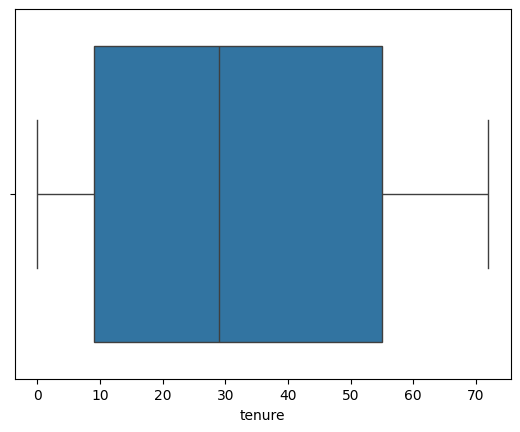

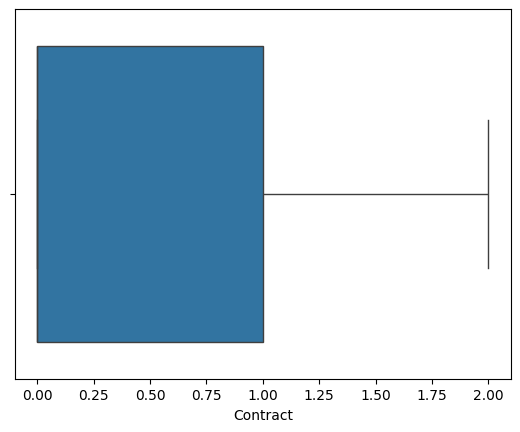

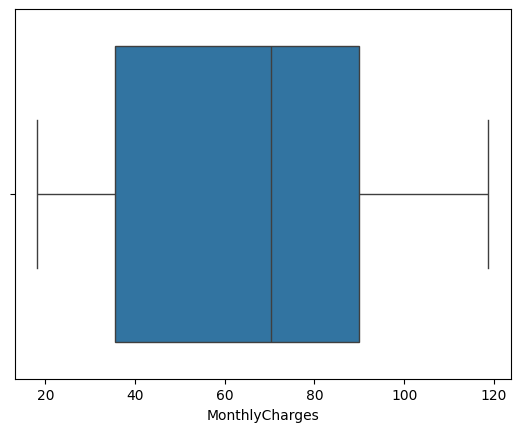

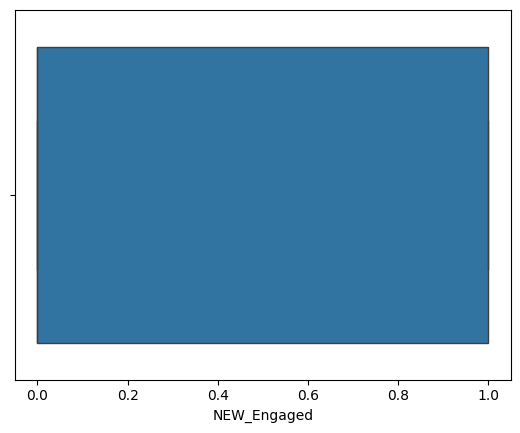

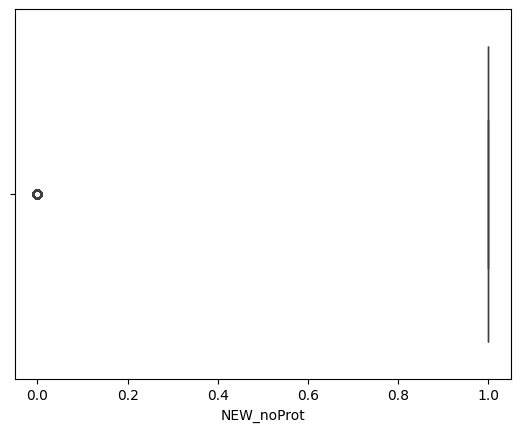

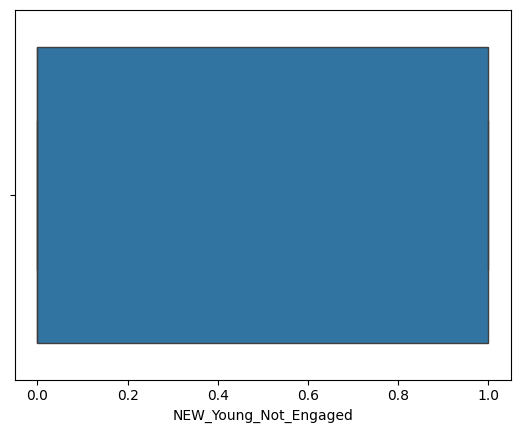

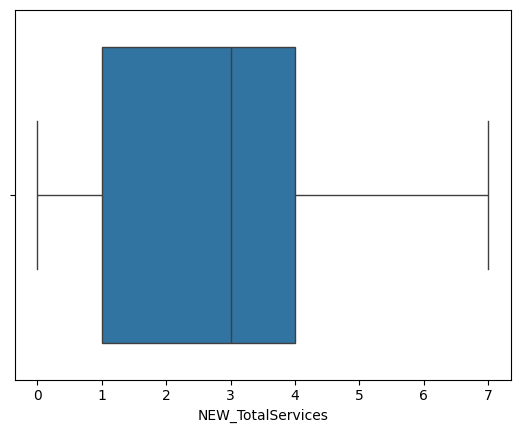

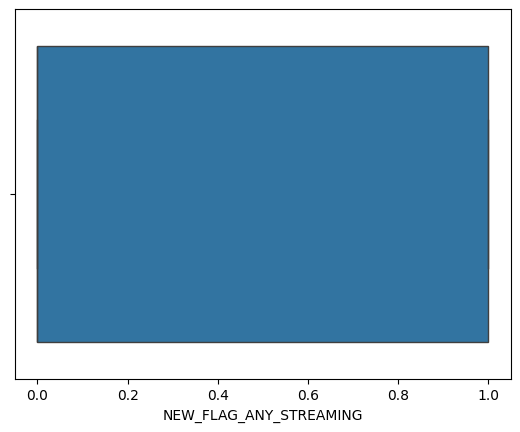

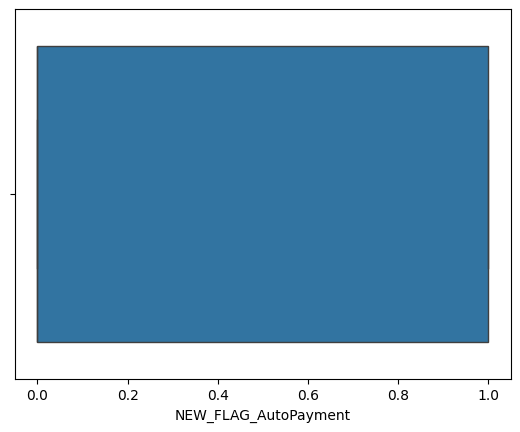

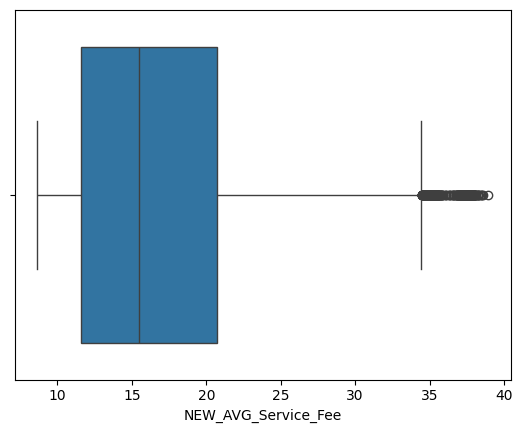

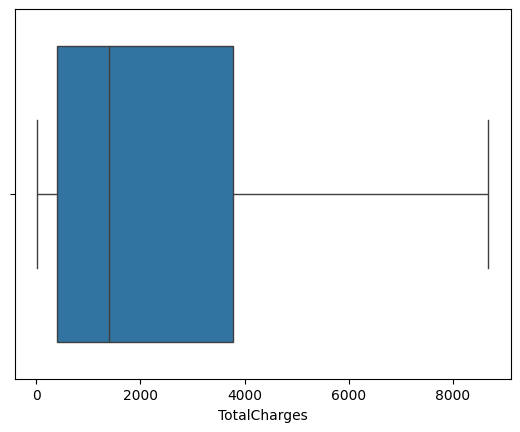

In [658]:
# visualizing outliers by box plot

for i in df_num:
    sns.boxplot(x=dataset[i])
    plt.show()

In [659]:
# Detecting outliers

def detect_outliers_iqr(series):
  q1, q3 = series.quantile([0.25, 0.75])
  iqr = q3 - q1
  lower_bound = q1 - 1.5 * iqr
  upper_bound = q3 + 1.5 * iqr
  return series[(series < lower_bound) | (series > upper_bound)]


for i in df_num:
    print(detect_outliers_iqr(dataset[i]))

Series([], Name: tenure, dtype: int64)
Series([], Name: Contract, dtype: int64)
Series([], Name: MonthlyCharges, dtype: float64)
Series([], Name: NEW_Engaged, dtype: int64)
15      0
28      0
30      0
32      0
43      0
       ..
6982    0
6983    0
6995    0
7007    0
7036    0
Name: NEW_noProt, Length: 726, dtype: int64
Series([], Name: NEW_Young_Not_Engaged, dtype: int64)
Series([], Name: NEW_TotalServices, dtype: int64)
Series([], Name: NEW_FLAG_ANY_STREAMING, dtype: int64)
Series([], Name: NEW_FLAG_AutoPayment, dtype: int64)
4       35.350
36      34.850
113     38.250
122     37.200
139     35.225
         ...  
7010    37.225
7018    35.325
7032    37.875
7033    34.750
7041    37.200
Name: NEW_AVG_Service_Fee, Length: 392, dtype: float64
Series([], Name: TotalCharges, dtype: float64)


In [660]:
# Split dataset into features (X) and target (y)
X = dataset.drop('Churn', axis=1)
y = dataset['Churn']


In [661]:
# Apply SMOTEENN for both oversampling and cleaning
smote_enn = SMOTEENN(random_state=42)
X_res, y_res = smote_enn.fit_resample(X, y)

df = pd.concat([X_res, y_res], axis=1)

print(pd.Series(y_res).value_counts())

Churn
1    3325
0    2723
Name: count, dtype: int64


In [662]:
# scaling columns using standard scaler

cols_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges', 'NEW_Increase', 'NEW_AVG_Charges', 'NEW_AVG_Service_Fee'

                 ]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])


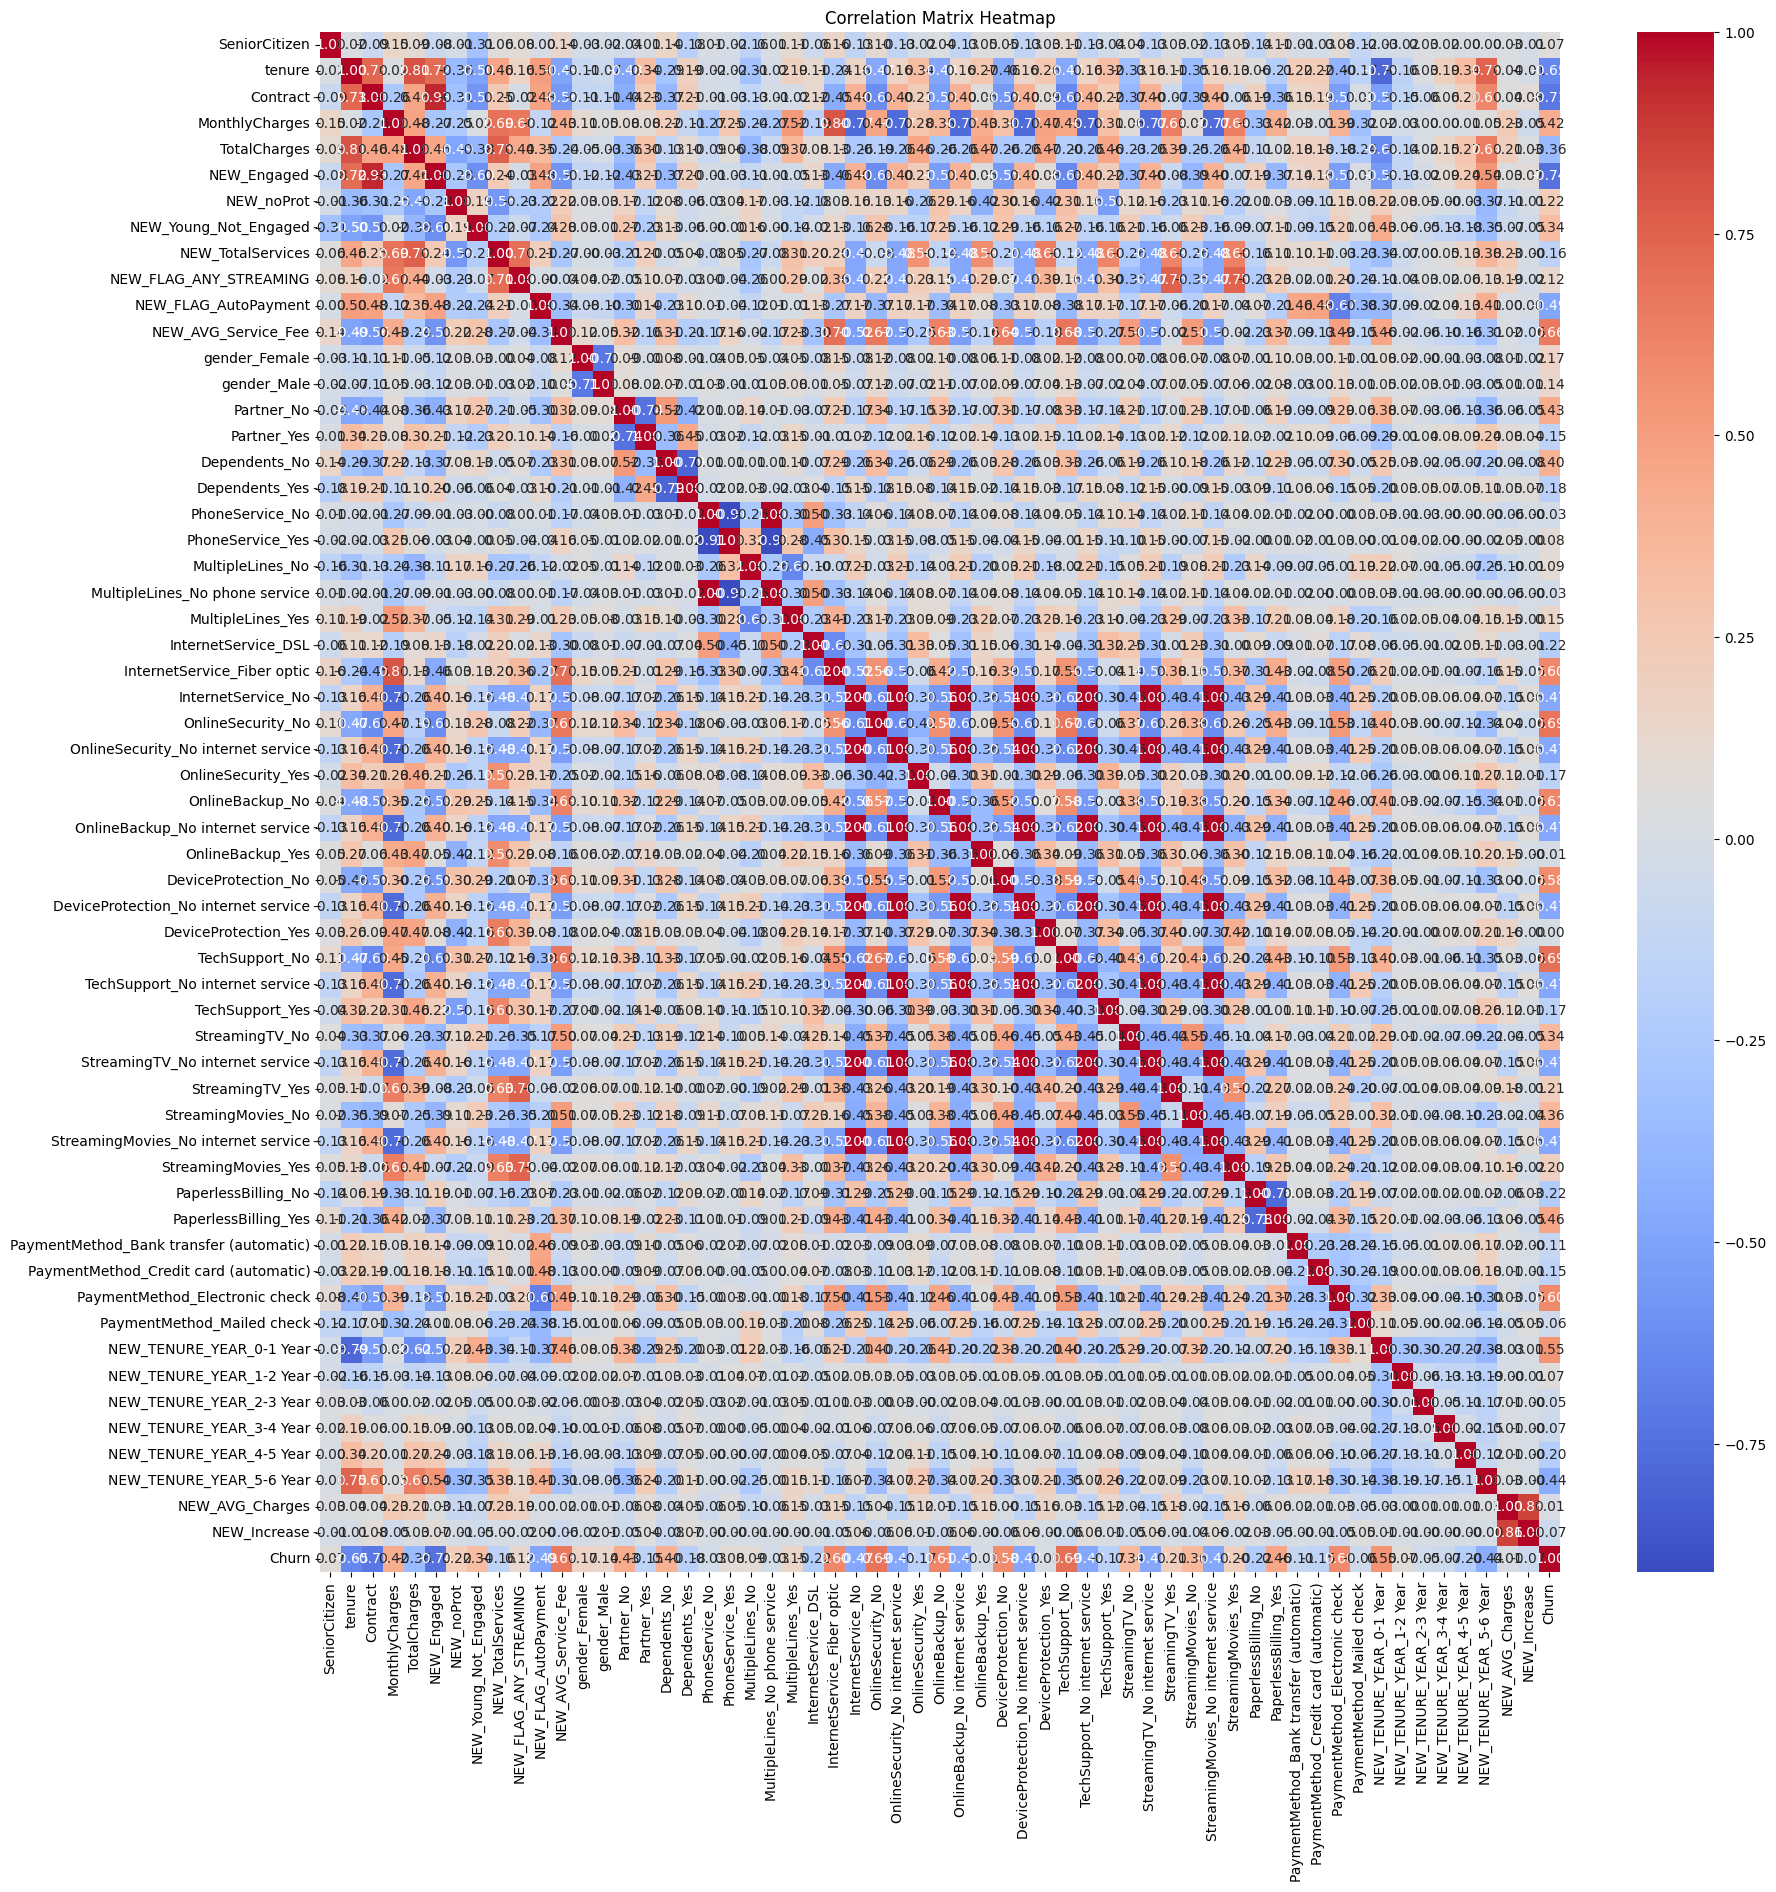

In [663]:
# visualizing the corr between the faetures
corr_matrix = df.corr()

plt.figure(figsize = (20, 20))
sns.heatmap(corr_matrix, annot = True, fmt = '.2f', cmap = 'coolwarm', cbar = True)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [664]:
# features that are highly correlated with the target variable
corr_with_target = corr_matrix['Churn'].sort_values(ascending = False)
print(corr_with_target)

Churn                                      1.000000
TechSupport_No                             0.694761
OnlineSecurity_No                          0.685967
NEW_AVG_Service_Fee                        0.658108
OnlineBackup_No                            0.610082
InternetService_Fiber optic                0.601845
PaymentMethod_Electronic check             0.596583
DeviceProtection_No                        0.581008
NEW_TENURE_YEAR_0-1 Year                   0.550814
PaperlessBilling_Yes                       0.462372
Partner_No                                 0.430013
MonthlyCharges                             0.418700
Dependents_No                              0.401821
StreamingMovies_No                         0.359222
StreamingTV_No                             0.343934
NEW_Young_Not_Engaged                      0.338929
NEW_noProt                                 0.220836
StreamingTV_Yes                            0.206686
StreamingMovies_Yes                        0.198638
gender_Femal

In [665]:
# Split data
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=42)

In [666]:
# using logistic regression to know how well steps works

model = LogisticRegression(max_iter=1000)

# Train the model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [667]:
# score
score = model.score(X_train, y_train)
print(f'Score : {score : }')
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


# Classification Report
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_rep)

Score :  0.956274113540327
Accuracy: 0.9570247933884297
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95       284
           1       0.96      0.96      0.96       321

    accuracy                           0.96       605
   macro avg       0.96      0.96      0.96       605
weighted avg       0.96      0.96      0.96       605



[[270  14]
 [ 12 309]]


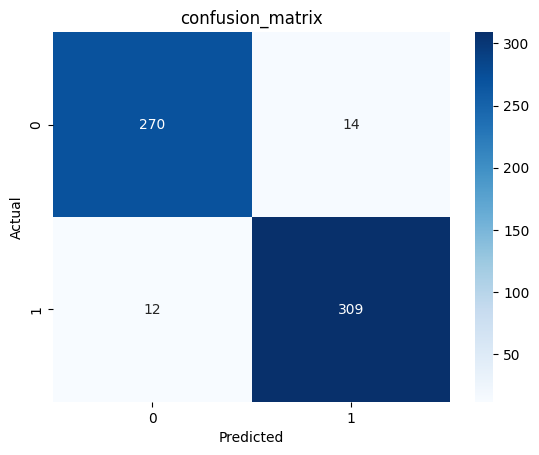

In [668]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues')
plt.title('confusion_matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

ROC AUC Score: 0.9928151463296915


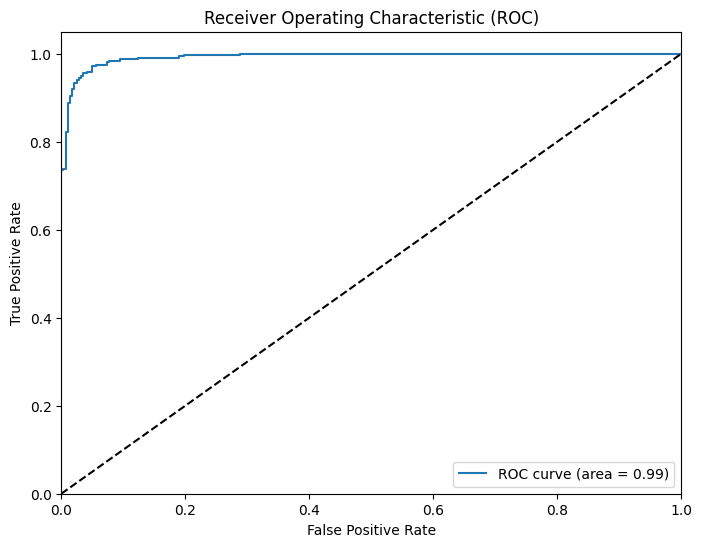

In [669]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict probabilities for the positive class
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [670]:
# Initialize and train the RandomForest model
random = RandomForestClassifier(n_estimators = 200, criterion = 'entropy', random_state = 150)   # Random_state = 2 is the best
random.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rand = random.predict(X_test)

In [671]:
# Evaluate the model
score = random.score(X_train, y_train)
print(f'Score : {score : }')
accuracy =  accuracy_score(y_test, y_pred_rand)
print(f'Accuracy : {accuracy : }')


print(classification_report(y_test, y_pred_rand))

Score :  1.0
Accuracy :  0.971900826446281
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       284
           1       0.97      0.98      0.97       321

    accuracy                           0.97       605
   macro avg       0.97      0.97      0.97       605
weighted avg       0.97      0.97      0.97       605



[[273  11]
 [  6 315]]


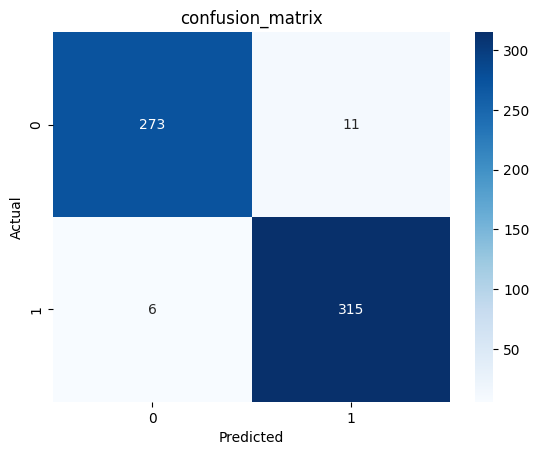

In [672]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_rand)
print(conf_matrix)
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues')
plt.title('confusion_matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# random_estate = 42
# Score :  1.0
# Accuracy :  0.9702479338842975
# Confusion Matrix:
#  [[273  11]
#  [  7 314]]
#               precision    recall  f1-score   support

#            0       0.97      0.96      0.97       284
#            1       0.97      0.98      0.97       321

#     accuracy                           0.97       605
#    macro avg       0.97      0.97      0.97       605
# weighted avg       0.97      0.97      0.97       605

In [ ]:
# random_state = 42
# Score :  1.0
# Accuracy :  0.9434276206322796
# Confusion Matrix:
#  [[533  29]
#  [ 39 601]]
#               precision    recall  f1-score   support

#            0       0.93      0.95      0.94       562
#            1       0.95      0.94      0.95       640

#     accuracy                           0.94      1202
#    macro avg       0.94      0.94      0.94      1202
# weighted avg       0.94      0.94      0.94      1202

ROC AUC Score: 0.99482251766048


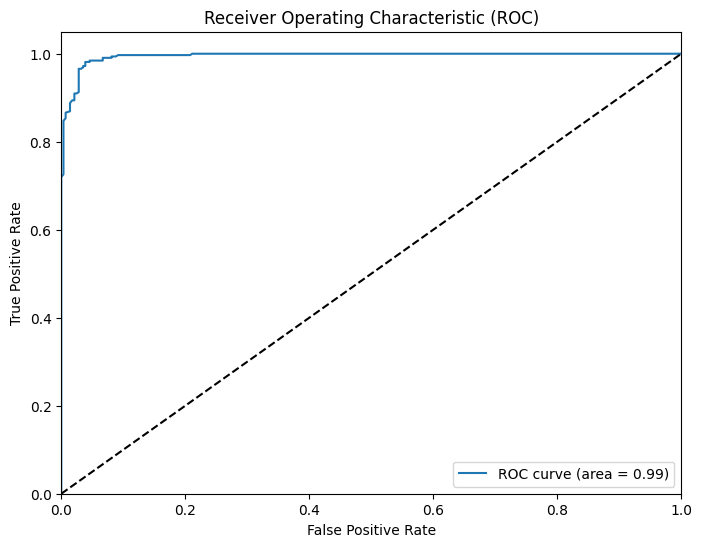

In [673]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict probabilities for the positive class
y_pred_proba = random.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [674]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

In [675]:
# Evaluate the model
score = xgb.score(X_train, y_train)
print(f'Score : {score : }')
accuracy =  accuracy_score(y_test, y_pred_xgb)
print(f'Accuracy : {accuracy : }')


print(classification_report(y_test, y_pred_xgb))

Score :  0.9998162777879845
Accuracy :  0.9652892561983472
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       284
           1       0.97      0.97      0.97       321

    accuracy                           0.97       605
   macro avg       0.97      0.97      0.97       605
weighted avg       0.97      0.97      0.97       605



[[274  10]
 [ 11 310]]


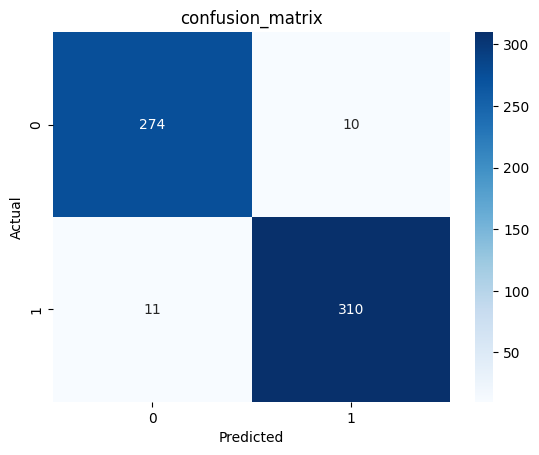

In [676]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
print(conf_matrix)
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues')
plt.title('confusion_matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Score :  0.9998162777879845
# Accuracy :  0.9652892561983472
# Confusion Matrix:
#  [[274  10]
#  [ 11 310]]
#               precision    recall  f1-score   support

#            0       0.96      0.96      0.96       284
#            1       0.97      0.97      0.97       321

#     accuracy                           0.97       605
#    macro avg       0.97      0.97      0.97       605
# weighted avg       0.97      0.97      0.97       605


In [ ]:
# Score :  0.9993759101310589
# Accuracy :  0.9409317803660566
# Confusion Matrix:
#  [[533  29]
#  [ 42 598]]
#               precision    recall  f1-score   support

#            0       0.93      0.95      0.94       562
#            1       0.95      0.93      0.94       640

#     accuracy                           0.94      1202
#    macro avg       0.94      0.94      0.94      1202
# weighted avg       0.94      0.94      0.94      1202


ROC AUC Score: 0.9953929182572068


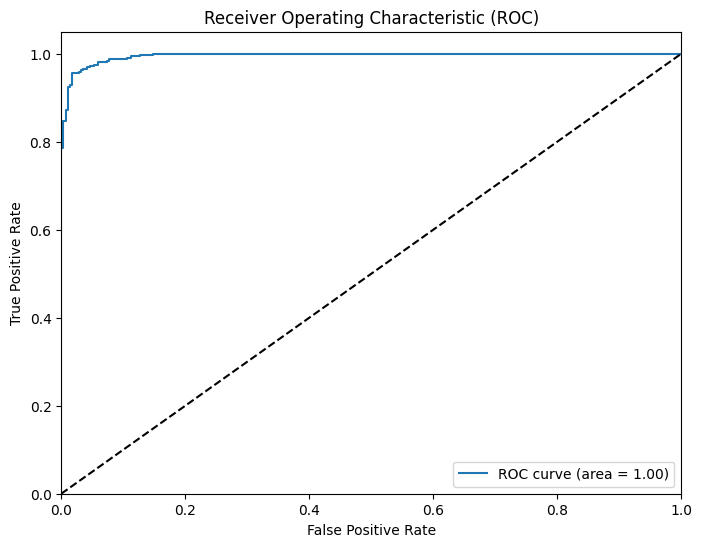

In [677]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict probabilities for the positive class
y_pred_proba = xgb.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [678]:
# Initialize and train the GaussianNB model
gnb = GaussianNB()
gnb.fit(X_train, y_train)
# Predict on the test set
y_pred_gnb = gnb.predict(X_test)

In [679]:
# Evaluate the model
score = gnb.score(X_train, y_train)
print(f'Score : {score : }')
accuracy =  accuracy_score(y_test, y_pred)
print(f'Accuracy : {accuracy : }')


print(classification_report(y_test, y_pred_gnb))

Score :  0.897666727907404
Accuracy :  0.9570247933884297
              precision    recall  f1-score   support

           0       0.94      0.85      0.89       284
           1       0.88      0.95      0.91       321

    accuracy                           0.91       605
   macro avg       0.91      0.90      0.90       605
weighted avg       0.91      0.91      0.91       605



[[242  42]
 [ 15 306]]


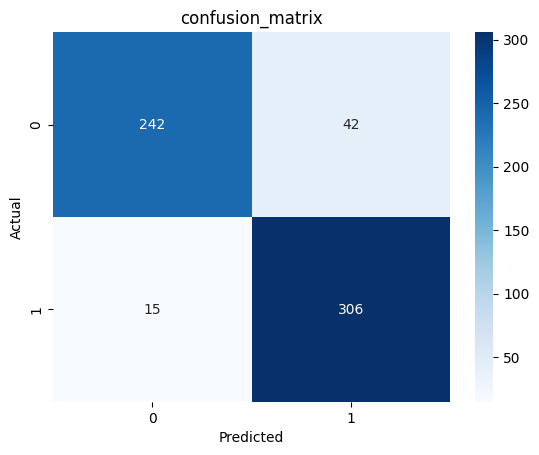

In [680]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_gnb)
print(conf_matrix)
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues')
plt.title('confusion_matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

ROC AUC Score: 0.9598141810363741


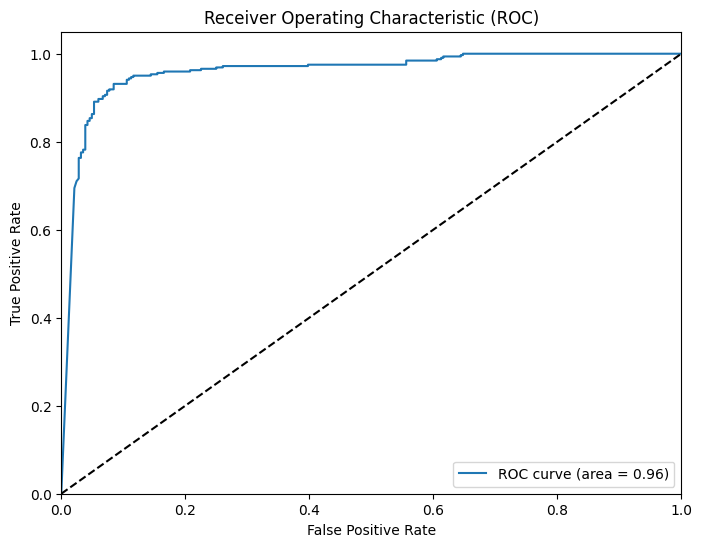

In [681]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict probabilities for the positive class
y_pred_proba = gnb.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [682]:
# prompt: make a voting based ensemble that takes all results from made models and create a new y_test_pred with the most frequent result

import numpy as np
from scipy.stats import mode

# Combine predictions from all models
all_predictions = np.array([y_pred, y_pred_xgb, y_pred_rand, y_pred_gnb])

# Find the most frequent prediction for each instance
y_test_pred = mode(all_predictions, axis=0)[0]

In [683]:
y_test_pred

array([1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,

In [684]:
# Evaluate the logistic regressin model
score = model.score(X_train, y_train)
print(f'Score : {score : }')
accuracy =  accuracy_score(y_test, y_pred)
print(f'Accuracy : {accuracy : }')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n",conf_matrix)

print(classification_report(y_test, y_pred))

Score :  0.956274113540327
Accuracy :  0.9570247933884297
Confusion Matrix:
 [[270  14]
 [ 12 309]]
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       284
           1       0.96      0.96      0.96       321

    accuracy                           0.96       605
   macro avg       0.96      0.96      0.96       605
weighted avg       0.96      0.96      0.96       605



In [685]:
# Evaluate the logistic regressin model
score = random.score(X_train, y_train)
print(f'Score : {score : }')
accuracy =  accuracy_score(y_test, y_pred_rand)
print(f'Accuracy : {accuracy : }')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_rand)
print("Confusion Matrix:\n",conf_matrix)

print(classification_report(y_test, y_pred_rand))

Score :  1.0
Accuracy :  0.971900826446281
Confusion Matrix:
 [[273  11]
 [  6 315]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       284
           1       0.97      0.98      0.97       321

    accuracy                           0.97       605
   macro avg       0.97      0.97      0.97       605
weighted avg       0.97      0.97      0.97       605



In [686]:
# Evaluate the logistic regressin model
score = xgb.score(X_train, y_train)
print(f'Score : {score : }')
accuracy =  accuracy_score(y_test, y_pred_xgb)
print(f'Accuracy : {accuracy : }')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix:\n",conf_matrix)

print(classification_report(y_test, y_pred_xgb))

Score :  0.9998162777879845
Accuracy :  0.9652892561983472
Confusion Matrix:
 [[274  10]
 [ 11 310]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       284
           1       0.97      0.97      0.97       321

    accuracy                           0.97       605
   macro avg       0.97      0.97      0.97       605
weighted avg       0.97      0.97      0.97       605



In [687]:
# Evaluate the logistic regressin model
score = gnb.score(X_train, y_train)
print(f'Score : {score : }')
accuracy =  accuracy_score(y_test, y_pred_gnb)
print(f'Accuracy : {accuracy : }')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_gnb)
print("Confusion Matrix:\n",conf_matrix)

print(classification_report(y_test, y_pred_gnb))

Score :  0.897666727907404
Accuracy :  0.9057851239669421
Confusion Matrix:
 [[242  42]
 [ 15 306]]
              precision    recall  f1-score   support

           0       0.94      0.85      0.89       284
           1       0.88      0.95      0.91       321

    accuracy                           0.91       605
   macro avg       0.91      0.90      0.90       605
weighted avg       0.91      0.91      0.91       605



In [ ]:
# prompt: fine tune with grid search

from sklearn.model_selection import GridSearchCV

# Define the parameter grid for RandomForestClassifier
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Use the best model for prediction
best_rf_model = grid_search.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)

# Evaluate the best model
accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
print("Accuracy of best Random Forest model:", accuracy_best_rf)
print(classification_report(y_test, y_pred_best_rf))


Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score: 0.9413383927431795
Accuracy of best Random Forest model: 0.9392678868552413
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       562
           1       0.95      0.94      0.94       640

    accuracy                           0.94      1202
   macro avg       0.94      0.94      0.94      1202
weighted avg       0.94      0.94      0.94      1202



In [ ]:
# prompt: hyper pramater tuning for all models i used in

import numpy as np
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for Logistic Regression
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # Suitable for smaller datasets and L1 regularization
}
grid_search_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5, scoring='accuracy')
grid_search_lr.fit(X_train, y_train)
print("Best parameters for Logistic Regression:", grid_search_lr.best_params_)
print("Best score for Logistic Regression:", grid_search_lr.best_score_)


# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)
print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print("Best score for Random Forest:", grid_search_rf.best_score_)


# Hyperparameter tuning for XGBoost
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}
grid_search_xgb = GridSearchCV(XGBClassifier(), param_grid_xgb, cv=5, scoring='accuracy')
grid_search_xgb.fit(X_train, y_train)
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)
print("Best score for XGBoost:", grid_search_xgb.best_score_)


# Hyperparameter tuning for GaussianNB (limited options)
# param_grid_gnb = {
#     'var_smoothing': np.logspace(0,-9, num=100)
# }
# grid_search_gnb = GridSearchCV(GaussianNB(), param_grid_gnb, cv=5, scoring='accuracy')
# grid_search_gnb.fit(X_train, y_train)
# print("Best parameters for GaussianNB:", grid_search_gnb.best_params_)
# print("Best score for GaussianNB:", grid_search_gnb.best_score_)


Best parameters for Logistic Regression: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best score for Logistic Regression: 0.9549394480672098
Best parameters for Random Forest: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best score for Random Forest: 0.9543185450443137
Best parameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.9}
Best score for XGBoost: 0.9574200688847675


In [ ]:
# prompt: hyper pramater tuning for all models i used in random parameters make randn

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Hyperparameter tuning for Logistic Regression
param_dist_lr = {
    'C': uniform(loc=0.001, scale=100),  # Use uniform distribution for C
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
random_search_lr = RandomizedSearchCV(LogisticRegression(max_iter=1000), param_distributions=param_dist_lr, n_iter=20, cv=5, scoring='accuracy', random_state=42)
random_search_lr.fit(X_train, y_train)
print("Best parameters for Logistic Regression:", random_search_lr.best_params_)
print("Best score for Logistic Regression:", random_search_lr.best_score_)


# Hyperparameter tuning for Random Forest
param_dist_rf = {
    'n_estimators': randint(50, 200),  # Use randint for n_estimators
    'max_depth': [None, 10, 20, 30],  # You can add more values
    'min_samples_split': randint(2, 10),  # Use randint
    'min_samples_leaf': randint(1, 4),  # Use randint
    'criterion': ['gini', 'entropy']
}
random_search_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_dist_rf, n_iter=20, cv=5, scoring='accuracy', random_state=42)
random_search_rf.fit(X_train, y_train)
print("Best parameters for Random Forest:", random_search_rf.best_params_)
print("Best score for Random Forest:", random_search_rf.best_score_)


# Hyperparameter tuning for XGBoost
param_dist_xgb = {
    'learning_rate': uniform(loc=0.01, scale=0.2),  # Use uniform distribution
    'max_depth': randint(3, 10),  # Use randint
    'n_estimators': randint(50, 200),  # Use randint
    'subsample': uniform(loc=0.8, scale=0.2),  # Use uniform distribution
    'colsample_bytree': uniform(loc=0.8, scale=0.2)  # Use uniform distribution
}
random_search_xgb = RandomizedSearchCV(XGBClassifier(), param_distributions=param_dist_xgb, n_iter=20, cv=5, scoring='accuracy', random_state=42)
random_search_xgb.fit(X_train, y_train)
print("Best parameters for XGBoost:", random_search_xgb.best_params_)
print("Best score for XGBoost:", random_search_xgb.best_score_)


# Hyperparameter tuning for KNN
param_dist_knn = {
    'n_neighbors': randint(1, 20),  # Use randint for n_neighbors
    'weights': ['uniform', 'distance'],  # Options for weights
    'metric': ['euclidean', 'manhattan']  # Options for distance metric
}
random_search_knn = RandomizedSearchCV(KNeighborsClassifier(), param_distributions=param_dist_knn, n_iter=20, cv=5, scoring='accuracy', random_state=42)
random_search_knn.fit(X_train, y_train)
print("Best parameters for KNN:", random_search_knn.best_params_)
print("Best score for KNN:", random_search_knn.best_score_)

# Hyperparameter tuning for GaussianNB (limited options)
param_dist_gnb = {
    'var_smoothing': uniform(loc=1e-10, scale=1e-2)  # Use uniform distribution for var_smoothing
}
random_search_gnb = RandomizedSearchCV(GaussianNB(), param_distributions=param_dist_gnb, n_iter=20, cv=5, scoring='accuracy', random_state=42)
random_search_gnb.fit(X_train, y_train)
print("Best parameters for GaussianNB:", random_search_gnb.best_params_)
print("Best score for GaussianNB:", random_search_gnb.best_score_)


Best parameters for Logistic Regression: {'C': 70.80825777960456, 'penalty': 'l2', 'solver': 'liblinear'}
Best score for Logistic Regression: 0.9557218238535083
Best parameters for Random Forest: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 107}
Best score for Random Forest: 0.9568242586290715
Best parameters for XGBoost: {'colsample_bytree': 0.9302154051003889, 'learning_rate': 0.19299193510875617, 'max_depth': 3, 'n_estimators': 121, 'subsample': 0.8898901348276407}
Best score for XGBoost: 0.9579275374061471
Best parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}
Best score for KNN: 0.9481899543563982
Best parameters for GaussianNB: {'var_smoothing': 0.002912291501980419}
Best score for GaussianNB: 0.8982152744017717


In [688]:
# choosing the final model depending on best test scores

classifier = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=np.nan, monotone_constraints='()',
              n_estimators=165, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity = 0, eval_metric='logloss')

classifier.fit(X_train, y_train)
yr_pred = classifier.predict(X_test)
# classifier.score(x_test, y_test)*100


# Evaluate the model
score = classifier.score(X_train, y_train)
print(f'Score : {score : }')
accuracy = accuracy_score(y_test, yr_pred)
print(f'Accuracy : {accuracy : }')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, yr_pred)
print("Confusion Matrix:\n", conf_matrix)

print(classification_report(y_test, yr_pred))

Score :  0.9988976667279074
Accuracy :  0.9553719008264463
Confusion Matrix:
 [[270  14]
 [ 13 308]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       284
           1       0.96      0.96      0.96       321

    accuracy                           0.96       605
   macro avg       0.96      0.96      0.96       605
weighted avg       0.96      0.96      0.96       605



In [689]:
# choosing the final model depending on best test scores

random = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)

random.fit(X_train, y_train)
y_pred = random.predict(X_test)

# Evaluate the model
score = random.score(X_train, y_train)
print(f'Score : {score : }')
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy : {accuracy : }')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

print(classification_report(y_test, y_pred))


Score :  0.9801580011023333
Accuracy :  0.9636363636363636
Confusion Matrix:
 [[270  14]
 [  8 313]]
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       284
           1       0.96      0.98      0.97       321

    accuracy                           0.96       605
   macro avg       0.96      0.96      0.96       605
weighted avg       0.96      0.96      0.96       605

